In this tutorial we extend on tutorial 4 by presenting some short notations available within MrBeam, studying a sparser array (EHT2022) and discuss some refinement steps. The first steps are analog to tutorial 4.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

import logging

from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.4 



In [2]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 64                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
rescaling = 0.0002              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1*10**10]       #cbar-lims for interactive plotting (brightness temperature)

Loading uvfits:  C:\Users\hendr\Documents\PhD\mr_beam\synthesis_regpy\examples/../synthetic_data/ring_eht2022_averaged.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  C:\Users\hendr\Documents\PhD\mr_beam\synthesis_regpy\examples/../synthetic_data/ring.fits


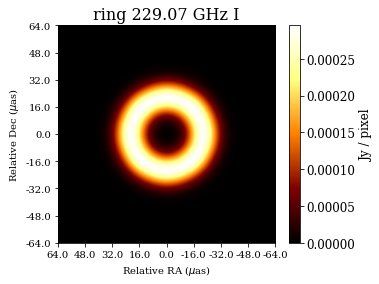

In [3]:
obs_sc = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_eht2022_averaged.uvfits')
exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

res = obs_sc.res()

In [4]:
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

Again we define widths of the wavelets manually by powers of 2.

In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#threshold for identifying gaps in uv-coverage
threshold = 0.01*10**9
#specify widths of wavelezs manually
widths = np.array([1, 2, 4, 6, 8, 12, 16])
#the final handler for the minimization procedure
handler = MinimizationHandler(res, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, [], [], widths=widths) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...


C:\Users\hendr\anaconda3\envs\mrbeam\lib\site-packages\ehtim\obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Generating I image...


The dirty image defines a proper first approximation to the true image structure and can be used as an initial guess. Moreover, we add a grid search for the best hard thresholds (proximal point operator of l0-penalty term is hard thresholding) per scale to minimize the objective functional of DoG-HiT (data fidelity term of closure quantities + l0 penalization on wavelets). This step finds a proper initial guess for the multiresolution support and helps global convergence, in particular for sparse arrays.

We use  5 scales with threshold 0.5
Current minimum 1639.112179372048
Start optimization with thresholds [1.e+04 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01]
reverse mode: True
Updated at scale 1 to threshold 0.0 to minimum 1277.4970144651784
Updated at scale 4 to threshold 1.0 to minimum 1250.735573271003


2022-07-27 16:34:41,245 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:34:41,247 INFO Display              :: Penalty--> 1882.4050918261955


We use thresholds:  [1.e+04 0.e+00 5.e-01 5.e-01 1.e+00 5.e-01 5.e-01]


2022-07-27 16:34:41,392 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:34:41,394 INFO Display              :: Penalty--> 1830.12023147802
2022-07-27 16:34:41,540 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:34:41,542 INFO Display              :: Penalty--> 1820.5961197125146
2022-07-27 16:34:41,681 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:34:41,683 INFO Display              :: Penalty--> 1807.5253916054153
2022-07-27 16:34:41,823 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:34:41,824 INFO Display              :: Penalty--> 1791.6610623599408
2022-07-27 16:34:41,958 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:34:41,959 INFO Display              :: Penalty--> 1779.2436673159982
2022-07-27 16:34:42,090 INFO CountIterations      :: iteration = 7 / 25
2022-07-27 16:34:42,091 INFO Display              :: Penalty--> 1766.7780082345223
2022-07-27 16:34:42,235 INFO CountIterations      :: iteration = 8 / 25


311.93884605874086
Data Fidelity:  348.9173970333268


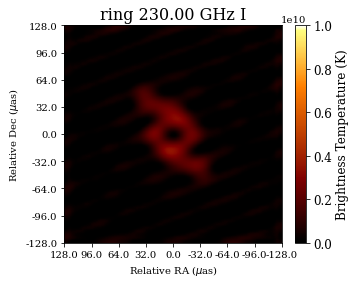

In [6]:
#Use dirty image as input image
img = obs_sc.dirtyimage(npix+1, fov)
data = handler.convert.ehtim_to_numpy(img)/rescaling

#Regularization parameters
alpha = 0.5
tau = 0.01

#Grid based search for best thresholds (l0 penalization) scale by scale 
init = handler.find_initial_guess(data, alpha)

#Define multiscalar weighting, flux transporting smoothing scale not supressed 
noise_levels = handler.noise_levels

wtfcts = handler.second_round(init, tau, alpha*noise_levels, maxiter=1, max_iterations=25, display=True)

reco = handler.op(wtfcts)
img = handler.wrapper.formatoutput(reco)

There is the shorter command handler.second_round_minimization that includes handler.find_initial_guess and handler.second_round for a more compact writing of the code. Again, we blur the image by the resolution and repeat the minimization to help global convergence.

We use  6 scales with threshold 4.0
Current minimum 1764.745797219714
Start optimization with thresholds [4. 4. 4. 4. 4. 4. 4.]
reverse mode: True
Updated at scale 0 to threshold 7.5 to minimum 1741.8335007427652
Updated at scale 0 to threshold 8.0 to minimum 1628.514915655801
Updated at scale 0 to threshold 8.5 to minimum 1622.8086108038065
Updated at scale 0 to threshold 9.5 to minimum 1599.6992568539745
Updated at scale 1 to threshold 7.0 to minimum 1598.888274339492
Updated at scale 1 to threshold 7.5 to minimum 1588.0516870269955
Updated at scale 1 to threshold 8.0 to minimum 1454.3597940324041
Updated at scale 1 to threshold 9.0 to minimum 1449.8140447813225
Updated at scale 2 to threshold 4.5 to minimum 1427.841712087671
Updated at scale 3 to threshold 2.5 to minimum 1411.787605979586
Updated at scale 4 to threshold 4.5 to minimum 1399.0252304554488
Updated at scale 5 to threshold 1.0 to minimum 1398.5876524369423
Updated at scale 5 to threshold 1.5 to minimum 1395.9283945452685

2022-07-27 16:35:03,286 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:03,288 INFO Display              :: Penalty--> 204.91862712564503
2022-07-27 16:35:03,424 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:03,427 INFO Display              :: Penalty--> 200.84300191308606
2022-07-27 16:35:03,565 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:03,567 INFO Display              :: Penalty--> 199.37210080181475
2022-07-27 16:35:03,708 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:03,710 INFO Display              :: Penalty--> 198.3026327515893
2022-07-27 16:35:03,863 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:03,865 INFO Display              :: Penalty--> 196.64020941569996
2022-07-27 16:35:04,004 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:04,006 INFO Display              :: Penalty--> 196.48699024892727
2022-07-27 16:35:04,144 INFO CountIterations      :: iteration = 7 / 25

1091.39635976618
Data Fidelity:  218.87529244362807


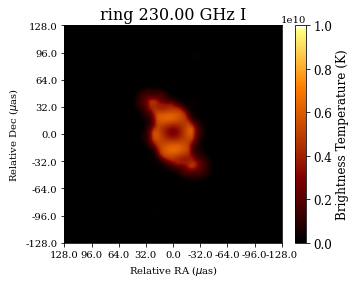

2022-07-27 16:35:07,103 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:07,105 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:07,250 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:07,251 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:07,383 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:07,384 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:07,520 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:07,522 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:07,662 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:07,665 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:07,818 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:07,820 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:07,984 INFO CountIterations      :: iteration = 7 / 2

2995.9225071818983
Data Fidelity:  190.3023713474517


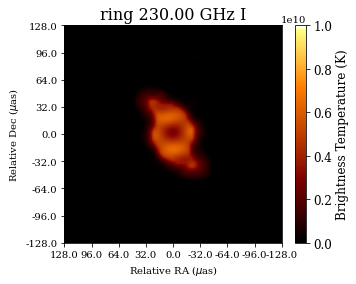

2022-07-27 16:35:11,020 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:11,023 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:11,165 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:11,166 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:11,303 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:11,305 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:11,454 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:11,456 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:11,605 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:11,607 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:11,742 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:11,744 INFO Display              :: Penalty--> 187.84850865296502
2022-07-27 16:35:11,905 INFO CountIterations      :: iteration = 7 / 2

2996.551162696424
Data Fidelity:  178.43650874128798


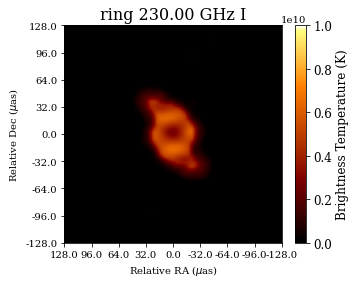

2022-07-27 16:35:15,049 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:15,051 INFO Display              :: Penalty--> 187.78722098625593
2022-07-27 16:35:15,180 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:15,182 INFO Display              :: Penalty--> 187.78722098625593
2022-07-27 16:35:15,329 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:15,331 INFO Display              :: Penalty--> 187.78722098625593
2022-07-27 16:35:15,470 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:15,472 INFO Display              :: Penalty--> 187.78722098625593
2022-07-27 16:35:15,631 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:15,633 INFO Display              :: Penalty--> 187.78722098625593
2022-07-27 16:35:15,780 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:15,782 INFO Display              :: Penalty--> 187.78722098625593
2022-07-27 16:35:15,922 INFO CountIterations      :: iteration = 7 / 2

2996.871125227037
Data Fidelity:  168.97919963335823


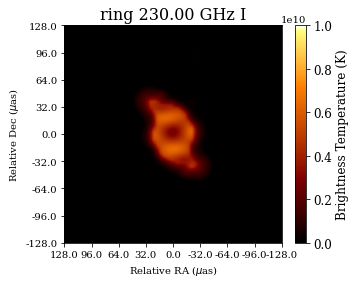

2022-07-27 16:35:19,081 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:19,083 INFO Display              :: Penalty--> 187.66311346117007
2022-07-27 16:35:19,231 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:19,232 INFO Display              :: Penalty--> 187.66311346117007
2022-07-27 16:35:19,390 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:19,392 INFO Display              :: Penalty--> 187.66311346117007
2022-07-27 16:35:19,531 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:19,532 INFO Display              :: Penalty--> 187.63246962781554
2022-07-27 16:35:19,663 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:19,665 INFO Display              :: Penalty--> 187.63246962781554
2022-07-27 16:35:19,810 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:19,812 INFO Display              :: Penalty--> 187.63246962781554
2022-07-27 16:35:19,944 INFO CountIterations      :: iteration = 7 / 2

2997.120577858458
Data Fidelity:  161.12938660679353


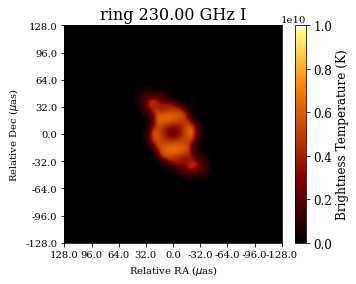

2022-07-27 16:35:22,865 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:22,867 INFO Display              :: Penalty--> 187.3857873472608
2022-07-27 16:35:23,000 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:23,002 INFO Display              :: Penalty--> 187.3857873472608
2022-07-27 16:35:23,173 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:23,174 INFO Display              :: Penalty--> 187.35514351390626
2022-07-27 16:35:23,313 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:23,315 INFO Display              :: Penalty--> 187.35514351390626
2022-07-27 16:35:23,454 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:23,456 INFO Display              :: Penalty--> 187.35514351390626
2022-07-27 16:35:23,588 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:23,590 INFO Display              :: Penalty--> 187.35514351390626
2022-07-27 16:35:23,726 INFO CountIterations      :: iteration = 7 / 25


2997.3015906826045
Data Fidelity:  154.4955013588705


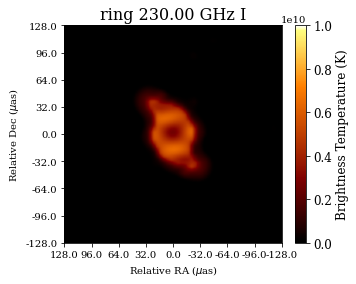

2022-07-27 16:35:26,654 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:26,656 INFO Display              :: Penalty--> 187.25401886383628
2022-07-27 16:35:26,810 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:26,811 INFO Display              :: Penalty--> 187.25401886383628
2022-07-27 16:35:26,975 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:26,977 INFO Display              :: Penalty--> 187.25401886383628
2022-07-27 16:35:27,133 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:27,135 INFO Display              :: Penalty--> 187.23563256382357
2022-07-27 16:35:27,266 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:27,268 INFO Display              :: Penalty--> 187.23563256382357
2022-07-27 16:35:27,404 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:27,405 INFO Display              :: Penalty--> 187.20498873046904
2022-07-27 16:35:27,535 INFO CountIterations      :: iteration = 7 / 2

2997.475224577851
Data Fidelity:  148.67680875342143


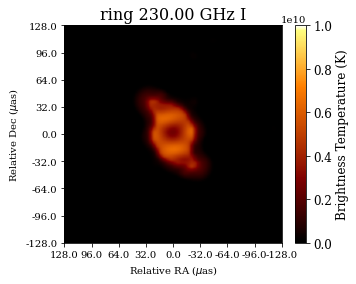

2022-07-27 16:35:30,652 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:30,653 INFO Display              :: Penalty--> 187.10233188873136
2022-07-27 16:35:30,782 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:30,784 INFO Display              :: Penalty--> 187.09160654705727
2022-07-27 16:35:30,921 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:30,923 INFO Display              :: Penalty--> 187.09160654705727
2022-07-27 16:35:31,056 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:31,058 INFO Display              :: Penalty--> 187.08088120538318
2022-07-27 16:35:31,198 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:31,200 INFO Display              :: Penalty--> 187.08088120538318
2022-07-27 16:35:31,342 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:31,344 INFO Display              :: Penalty--> 187.08088120538318
2022-07-27 16:35:31,486 INFO CountIterations      :: iteration = 7 / 2

2997.6760318933525
Data Fidelity:  143.5227042175944


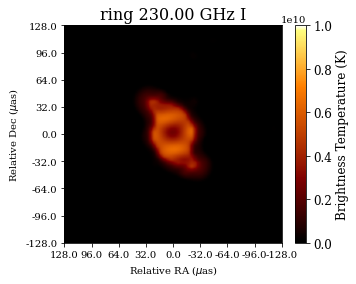

2022-07-27 16:35:34,517 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:34,518 INFO Display              :: Penalty--> 186.98894970531958
2022-07-27 16:35:34,656 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:34,658 INFO Display              :: Penalty--> 186.98894970531958
2022-07-27 16:35:34,797 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:34,799 INFO Display              :: Penalty--> 186.98894970531958
2022-07-27 16:35:34,932 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:34,932 INFO Display              :: Penalty--> 186.98894970531958
2022-07-27 16:35:35,077 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:35,079 INFO Display              :: Penalty--> 186.98894970531958
2022-07-27 16:35:35,225 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:35,227 INFO Display              :: Penalty--> 186.98894970531958
2022-07-27 16:35:35,360 INFO CountIterations      :: iteration = 7 / 2

2997.839875549463
Data Fidelity:  138.75622477229578


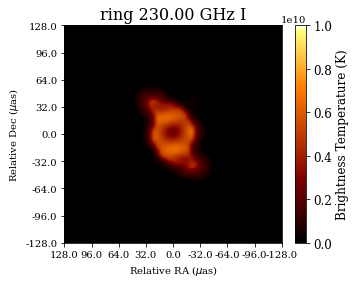

2022-07-27 16:35:38,384 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:38,386 INFO Display              :: Penalty--> 186.4434912054567
2022-07-27 16:35:38,530 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:38,531 INFO Display              :: Penalty--> 186.4434912054567
2022-07-27 16:35:38,668 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:38,670 INFO Display              :: Penalty--> 186.4434912054567
2022-07-27 16:35:38,804 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:38,806 INFO Display              :: Penalty--> 186.4434912054567
2022-07-27 16:35:38,935 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:38,937 INFO Display              :: Penalty--> 186.41284737210214
2022-07-27 16:35:39,071 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:39,073 INFO Display              :: Penalty--> 186.41284737210214
2022-07-27 16:35:39,221 INFO CountIterations      :: iteration = 7 / 25
20

2997.958233034946
Data Fidelity:  134.4792888553282


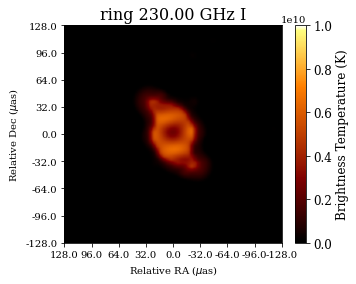

2022-07-27 16:35:42,236 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:42,238 INFO Display              :: Penalty--> 186.08342674149017
2022-07-27 16:35:42,371 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:42,373 INFO Display              :: Penalty--> 186.05278290813564
2022-07-27 16:35:42,505 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:42,507 INFO Display              :: Penalty--> 186.05278290813564
2022-07-27 16:35:42,637 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:42,639 INFO Display              :: Penalty--> 186.05278290813564
2022-07-27 16:35:42,765 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:42,767 INFO Display              :: Penalty--> 186.02213907478108
2022-07-27 16:35:42,905 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:42,906 INFO Display              :: Penalty--> 186.02213907478108
2022-07-27 16:35:43,055 INFO CountIterations      :: iteration = 7 / 2

2998.071715650275
Data Fidelity:  130.5903321657693


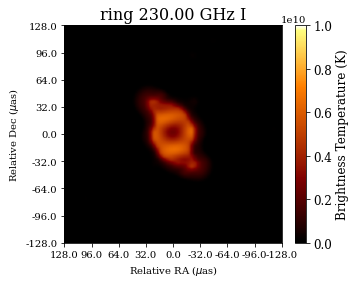

2022-07-27 16:35:46,050 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:46,052 INFO Display              :: Penalty--> 185.93020757471749
2022-07-27 16:35:46,186 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:46,188 INFO Display              :: Penalty--> 185.93020757471749
2022-07-27 16:35:46,321 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:46,322 INFO Display              :: Penalty--> 185.93020757471749
2022-07-27 16:35:46,452 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:46,454 INFO Display              :: Penalty--> 185.93020757471749
2022-07-27 16:35:46,581 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:46,583 INFO Display              :: Penalty--> 185.93020757471749
2022-07-27 16:35:46,728 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:46,731 INFO Display              :: Penalty--> 185.93020757471749
2022-07-27 16:35:46,869 INFO CountIterations      :: iteration = 7 / 2

2998.1802792909093
Data Fidelity:  127.02368217568124


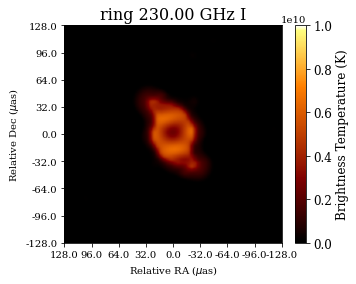

2022-07-27 16:35:49,774 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:49,776 INFO Display              :: Penalty--> 185.89956374136295
2022-07-27 16:35:49,929 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:49,931 INFO Display              :: Penalty--> 185.89956374136295
2022-07-27 16:35:50,085 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:50,086 INFO Display              :: Penalty--> 185.89956374136295
2022-07-27 16:35:50,224 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:50,226 INFO Display              :: Penalty--> 185.86891990800842
2022-07-27 16:35:50,360 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:50,362 INFO Display              :: Penalty--> 185.86891990800842
2022-07-27 16:35:50,491 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:50,493 INFO Display              :: Penalty--> 185.86891990800842
2022-07-27 16:35:50,632 INFO CountIterations      :: iteration = 7 / 2

2998.223448420701
Data Fidelity:  123.60595770016485


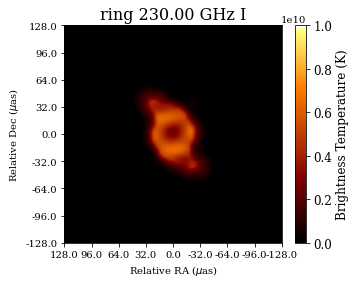

2022-07-27 16:35:53,630 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:53,632 INFO Display              :: Penalty--> 185.46901903863028
2022-07-27 16:35:53,775 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:53,777 INFO Display              :: Penalty--> 185.43837520527575
2022-07-27 16:35:53,919 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:53,921 INFO Display              :: Penalty--> 185.43837520527575
2022-07-27 16:35:54,064 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:54,066 INFO Display              :: Penalty--> 185.43071424693713
2022-07-27 16:35:54,213 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:54,215 INFO Display              :: Penalty--> 185.42305328859848
2022-07-27 16:35:54,351 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:54,353 INFO Display              :: Penalty--> 185.42305328859848
2022-07-27 16:35:54,479 INFO CountIterations      :: iteration = 7 / 2

2998.3809471059817
Data Fidelity:  120.44366804432772


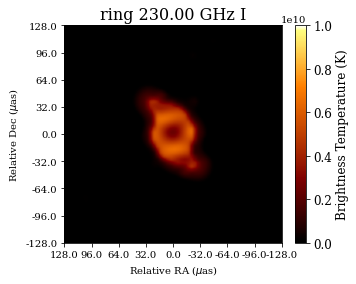

2022-07-27 16:35:57,587 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:35:57,589 INFO Display              :: Penalty--> 185.33112178853486
2022-07-27 16:35:57,727 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:35:57,729 INFO Display              :: Penalty--> 185.30047795518033
2022-07-27 16:35:57,862 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:35:57,864 INFO Display              :: Penalty--> 185.30047795518033
2022-07-27 16:35:57,997 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:35:57,999 INFO Display              :: Penalty--> 185.30047795518033
2022-07-27 16:35:58,131 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:35:58,133 INFO Display              :: Penalty--> 185.30047795518033
2022-07-27 16:35:58,283 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:35:58,285 INFO Display              :: Penalty--> 185.30047795518033
2022-07-27 16:35:58,441 INFO CountIterations      :: iteration = 7 / 2

2998.4226484991723
Data Fidelity:  117.50362936099529


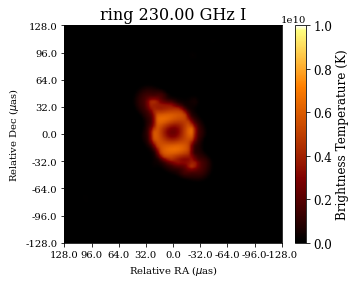

2022-07-27 16:36:01,385 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:01,387 INFO Display              :: Penalty--> 185.27902727183215
2022-07-27 16:36:01,508 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:01,510 INFO Display              :: Penalty--> 185.27902727183215
2022-07-27 16:36:01,636 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:01,638 INFO Display              :: Penalty--> 185.27902727183215
2022-07-27 16:36:01,802 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:01,804 INFO Display              :: Penalty--> 185.27902727183215
2022-07-27 16:36:01,944 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:01,946 INFO Display              :: Penalty--> 185.11355114966693
2022-07-27 16:36:02,090 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:02,092 INFO Display              :: Penalty--> 185.11355114966693
2022-07-27 16:36:02,226 INFO CountIterations      :: iteration = 7 / 2

2998.48515976769
Data Fidelity:  114.69577206011321


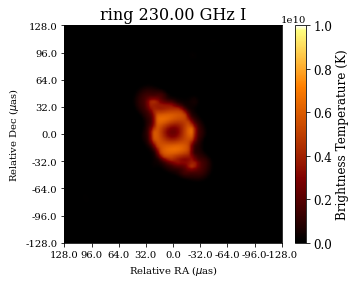

2022-07-27 16:36:05,112 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:05,114 INFO Display              :: Penalty--> 185.05226348295787
2022-07-27 16:36:05,246 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:05,248 INFO Display              :: Penalty--> 185.05226348295787
2022-07-27 16:36:05,390 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:05,392 INFO Display              :: Penalty--> 185.05226348295787
2022-07-27 16:36:05,517 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:05,518 INFO Display              :: Penalty--> 185.05226348295787
2022-07-27 16:36:05,643 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:05,645 INFO Display              :: Penalty--> 185.05226348295787
2022-07-27 16:36:05,787 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:05,789 INFO Display              :: Penalty--> 185.05226348295787
2022-07-27 16:36:05,934 INFO CountIterations      :: iteration = 7 / 2

2998.535902886745
Data Fidelity:  112.06733579969158


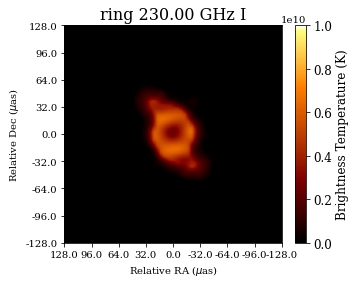

2022-07-27 16:36:08,869 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:08,871 INFO Display              :: Penalty--> 184.9725895162361
2022-07-27 16:36:08,997 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:08,999 INFO Display              :: Penalty--> 184.9725895162361
2022-07-27 16:36:09,133 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:09,135 INFO Display              :: Penalty--> 184.961864174562
2022-07-27 16:36:09,262 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:09,263 INFO Display              :: Penalty--> 184.961864174562
2022-07-27 16:36:09,392 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:09,394 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:09,545 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:09,547 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:09,676 INFO CountIterations      :: iteration = 7 / 25
2022

2998.5720143606604
Data Fidelity:  109.57960036145592


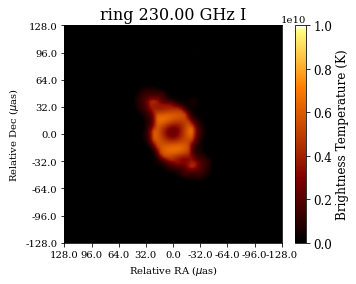

2022-07-27 16:36:12,584 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:12,586 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:12,735 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:12,736 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:12,893 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:12,895 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:13,035 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:13,037 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:13,188 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:13,191 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:13,354 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:13,356 INFO Display              :: Penalty--> 184.93122034120745
2022-07-27 16:36:13,482 INFO CountIterations      :: iteration = 7 / 2

2998.609514736195
Data Fidelity:  107.20681922083506


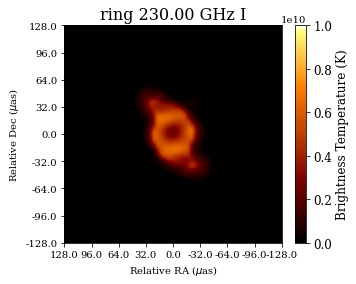

2022-07-27 16:36:16,462 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:16,464 INFO Display              :: Penalty--> 184.89291554951427
2022-07-27 16:36:16,605 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:16,607 INFO Display              :: Penalty--> 184.89291554951427
2022-07-27 16:36:16,728 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:16,730 INFO Display              :: Penalty--> 184.89291554951427
2022-07-27 16:36:16,874 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:16,876 INFO Display              :: Penalty--> 184.89291554951427
2022-07-27 16:36:17,017 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:17,020 INFO Display              :: Penalty--> 184.89291554951427
2022-07-27 16:36:17,180 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:17,182 INFO Display              :: Penalty--> 184.89291554951427
2022-07-27 16:36:17,347 INFO CountIterations      :: iteration = 7 / 2

2998.6563882711007
Data Fidelity:  104.90519063584281


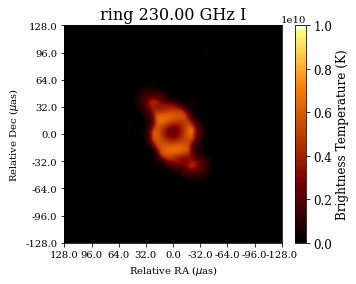

2022-07-27 16:36:20,282 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:20,283 INFO Display              :: Penalty--> 184.6554264189659
2022-07-27 16:36:20,423 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:20,424 INFO Display              :: Penalty--> 184.6554264189659
2022-07-27 16:36:20,552 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:20,553 INFO Display              :: Penalty--> 184.6554264189659
2022-07-27 16:36:20,696 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:20,698 INFO Display              :: Penalty--> 184.62478258561137
2022-07-27 16:36:20,841 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:20,842 INFO Display              :: Penalty--> 184.62478258561137
2022-07-27 16:36:20,969 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:20,970 INFO Display              :: Penalty--> 184.62478258561137
2022-07-27 16:36:21,099 INFO CountIterations      :: iteration = 7 / 25
2

2998.6530536208775
Data Fidelity:  102.74777728688531


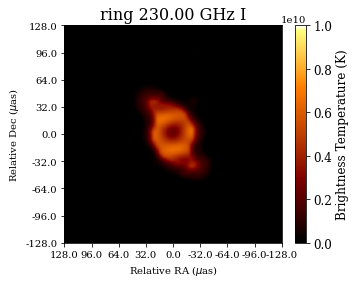

2022-07-27 16:36:24,123 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:24,125 INFO Display              :: Penalty--> 184.59413875225684
2022-07-27 16:36:24,253 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:24,255 INFO Display              :: Penalty--> 184.59413875225684
2022-07-27 16:36:24,398 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:24,399 INFO Display              :: Penalty--> 184.59413875225684
2022-07-27 16:36:24,538 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:24,540 INFO Display              :: Penalty--> 184.59413875225684
2022-07-27 16:36:24,663 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:24,665 INFO Display              :: Penalty--> 184.59413875225684
2022-07-27 16:36:24,800 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:24,801 INFO Display              :: Penalty--> 184.59413875225684
2022-07-27 16:36:24,935 INFO CountIterations      :: iteration = 7 / 2

2998.682017379616
Data Fidelity:  100.67998758235618


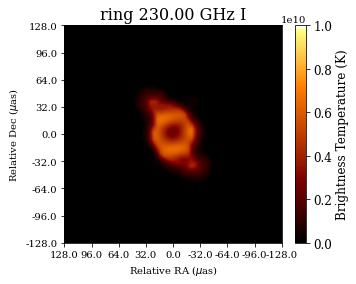

2022-07-27 16:36:27,887 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:27,889 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:28,022 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:28,024 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:28,152 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:28,154 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:28,285 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:28,287 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:28,422 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:28,424 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:28,560 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:28,562 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:28,694 INFO CountIterations      :: iteration = 7 / 25
2022

2998.702221177191
Data Fidelity:  98.69607897672985


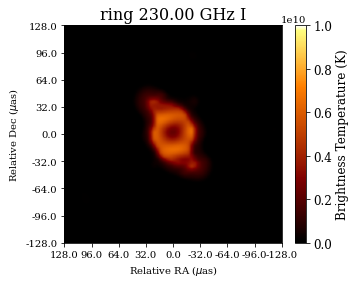

2022-07-27 16:36:31,676 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:31,678 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:31,808 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:31,810 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:31,966 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:31,968 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:32,100 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:32,101 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:32,228 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:32,230 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:32,361 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:32,363 INFO Display              :: Penalty--> 184.5221257438737
2022-07-27 16:36:32,495 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7172986468404
Data Fidelity:  96.78992773195645


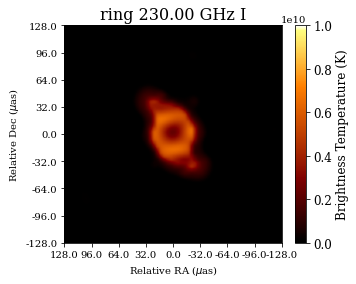

2022-07-27 16:36:35,528 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:35,529 INFO Display              :: Penalty--> 184.49148191051916
2022-07-27 16:36:35,661 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:35,662 INFO Display              :: Penalty--> 184.49148191051916
2022-07-27 16:36:35,790 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:35,791 INFO Display              :: Penalty--> 184.49148191051916
2022-07-27 16:36:35,913 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:35,915 INFO Display              :: Penalty--> 184.49148191051916
2022-07-27 16:36:36,057 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:36,059 INFO Display              :: Penalty--> 184.4608380771646
2022-07-27 16:36:36,183 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:36,185 INFO Display              :: Penalty--> 184.4608380771646
2022-07-27 16:36:36,329 INFO CountIterations      :: iteration = 7 / 25


2998.7303862229564
Data Fidelity:  94.94029106955313


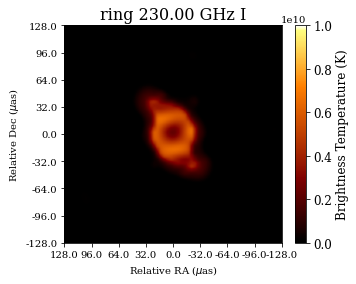

2022-07-27 16:36:39,350 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:39,352 INFO Display              :: Penalty--> 184.26471812164485
2022-07-27 16:36:39,503 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:39,505 INFO Display              :: Penalty--> 184.26471812164485
2022-07-27 16:36:39,641 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:39,643 INFO Display              :: Penalty--> 184.26471812164485
2022-07-27 16:36:39,770 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:39,772 INFO Display              :: Penalty--> 184.26471812164485
2022-07-27 16:36:39,924 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:39,926 INFO Display              :: Penalty--> 184.26471812164485
2022-07-27 16:36:40,050 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:40,052 INFO Display              :: Penalty--> 184.26471812164485
2022-07-27 16:36:40,187 INFO CountIterations      :: iteration = 7 / 2

2998.7416812495885
Data Fidelity:  93.15925270383568


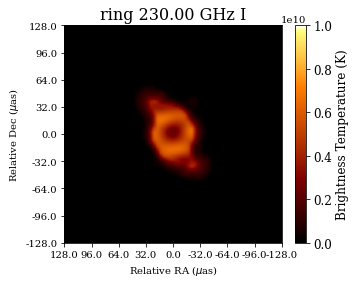

2022-07-27 16:36:43,127 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:43,129 INFO Display              :: Penalty--> 184.04714748277692
2022-07-27 16:36:43,256 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:43,258 INFO Display              :: Penalty--> 184.04714748277692
2022-07-27 16:36:43,392 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:43,394 INFO Display              :: Penalty--> 184.04714748277692
2022-07-27 16:36:43,550 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:43,552 INFO Display              :: Penalty--> 184.04714748277692
2022-07-27 16:36:43,687 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:43,688 INFO Display              :: Penalty--> 184.04714748277692
2022-07-27 16:36:43,821 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:43,823 INFO Display              :: Penalty--> 184.0165036494224
2022-07-27 16:36:43,959 INFO CountIterations      :: iteration = 7 / 25

2998.754278764056
Data Fidelity:  91.43171687358694


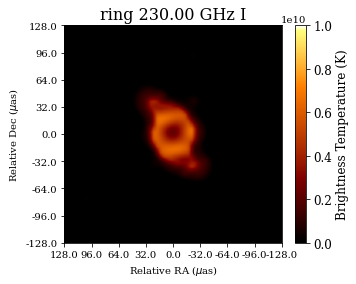

2022-07-27 16:36:47,211 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:47,214 INFO Display              :: Penalty--> 183.7897398605481
2022-07-27 16:36:47,368 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:47,370 INFO Display              :: Penalty--> 183.7897398605481
2022-07-27 16:36:47,527 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:47,529 INFO Display              :: Penalty--> 183.7897398605481
2022-07-27 16:36:47,660 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:47,662 INFO Display              :: Penalty--> 183.7897398605481
2022-07-27 16:36:47,789 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:47,791 INFO Display              :: Penalty--> 183.7897398605481
2022-07-27 16:36:47,923 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:47,925 INFO Display              :: Penalty--> 183.7897398605481
2022-07-27 16:36:48,063 INFO CountIterations      :: iteration = 7 / 25
2022

2998.740943357032
Data Fidelity:  89.76292741194288


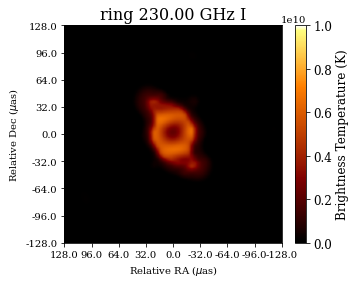

2022-07-27 16:36:51,063 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:51,064 INFO Display              :: Penalty--> 183.4710445716102
2022-07-27 16:36:51,199 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:51,200 INFO Display              :: Penalty--> 183.4710445716102
2022-07-27 16:36:51,365 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:51,367 INFO Display              :: Penalty--> 183.4710445716102
2022-07-27 16:36:51,498 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:51,500 INFO Display              :: Penalty--> 183.4710445716102
2022-07-27 16:36:51,627 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:51,629 INFO Display              :: Penalty--> 183.4710445716102
2022-07-27 16:36:51,751 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:51,753 INFO Display              :: Penalty--> 183.4710445716102
2022-07-27 16:36:51,884 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7630278827596
Data Fidelity:  88.15943818023811


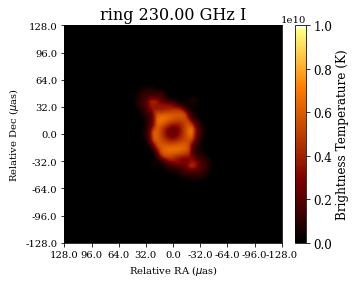

2022-07-27 16:36:54,942 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:54,943 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:55,077 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:55,079 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:55,218 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:55,221 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:55,372 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:55,374 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:55,504 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:55,506 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:55,638 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:55,640 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:55,757 INFO CountIterations      :: iteration = 7 / 2

2998.7593964428997
Data Fidelity:  86.65756495486802


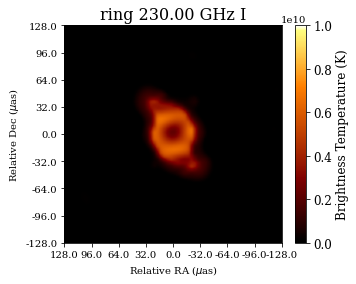

2022-07-27 16:36:58,745 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:36:58,747 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:58,860 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:36:58,862 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:59,029 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:36:59,031 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:59,195 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:36:59,196 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:59,326 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:36:59,329 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:59,459 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:36:59,461 INFO Display              :: Penalty--> 183.24428078273593
2022-07-27 16:36:59,579 INFO CountIterations      :: iteration = 7 / 2

2998.7566145384044
Data Fidelity:  85.18613860293334


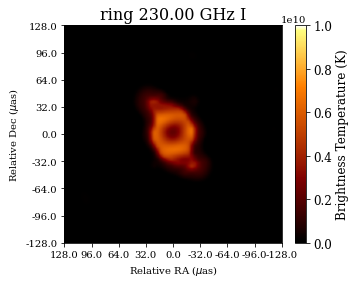

2022-07-27 16:37:02,477 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:02,478 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:02,607 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:02,609 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:02,738 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:02,740 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:02,866 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:02,868 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:02,987 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:02,989 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:03,116 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:03,117 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:03,238 INFO CountIterations      :: iteration = 7 / 25
2022

2998.755349378641
Data Fidelity:  83.77568505321277


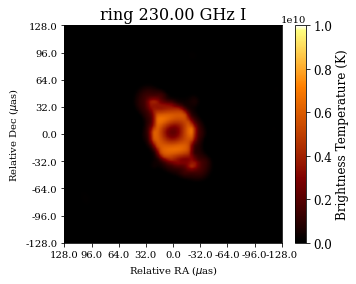

2022-07-27 16:37:06,166 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:06,168 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:06,316 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:06,318 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:06,450 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:06,452 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:06,584 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:06,587 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:06,705 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:06,706 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:06,821 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:06,823 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:06,942 INFO CountIterations      :: iteration = 7 / 25
2022

2998.751915285303
Data Fidelity:  82.40553930285063


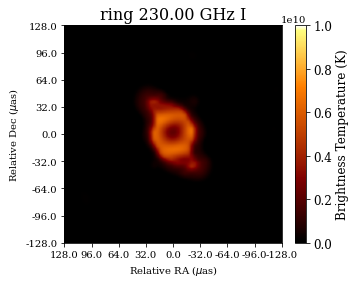

2022-07-27 16:37:09,712 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:09,714 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:09,845 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:09,847 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:09,989 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:09,991 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:10,116 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:10,118 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:10,237 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:10,239 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:10,360 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:10,362 INFO Display              :: Penalty--> 183.0788046605707
2022-07-27 16:37:10,490 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7607168661625
Data Fidelity:  81.06717188638856


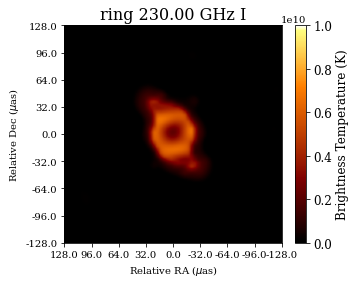

2022-07-27 16:37:13,233 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:13,235 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:13,374 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:13,376 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:13,506 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:13,508 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:13,649 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:13,651 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:13,785 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:13,787 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:13,919 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:13,921 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:14,034 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7395942393596
Data Fidelity:  79.77080153097171


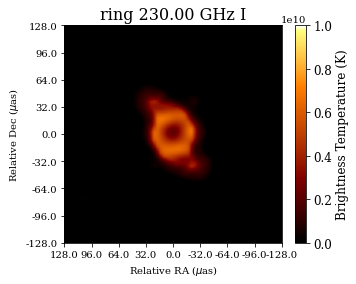

2022-07-27 16:37:17,115 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:17,117 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:17,259 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:17,261 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:17,396 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:17,398 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:17,537 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:17,539 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:17,673 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:17,675 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:17,828 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:17,829 INFO Display              :: Penalty--> 183.0374354855421
2022-07-27 16:37:17,953 INFO CountIterations      :: iteration = 7 / 25
2022

2998.737853367822
Data Fidelity:  78.50522128595546


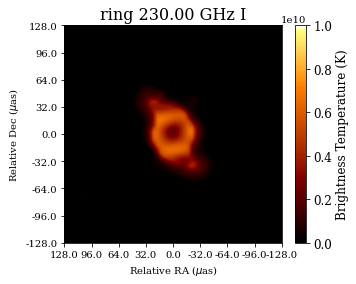

2022-07-27 16:37:20,793 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:20,795 INFO Display              :: Penalty--> 182.97614781883303
2022-07-27 16:37:20,920 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:20,922 INFO Display              :: Penalty--> 182.97614781883303
2022-07-27 16:37:21,045 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:21,048 INFO Display              :: Penalty--> 182.97614781883303
2022-07-27 16:37:21,171 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:21,172 INFO Display              :: Penalty--> 182.9455039854785
2022-07-27 16:37:21,297 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:21,299 INFO Display              :: Penalty--> 182.9455039854785
2022-07-27 16:37:21,427 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:21,428 INFO Display              :: Penalty--> 182.9455039854785
2022-07-27 16:37:21,559 INFO CountIterations      :: iteration = 7 / 25
2

2998.733776065748
Data Fidelity:  77.25627417848054


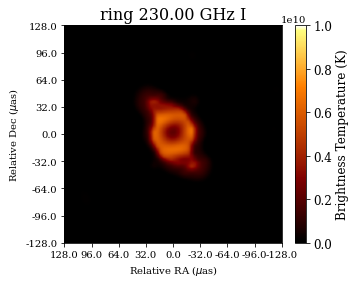

2022-07-27 16:37:24,372 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:24,373 INFO Display              :: Penalty--> 182.8842163187694
2022-07-27 16:37:24,507 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:24,510 INFO Display              :: Penalty--> 182.8842163187694
2022-07-27 16:37:24,638 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:24,640 INFO Display              :: Penalty--> 182.8842163187694
2022-07-27 16:37:24,775 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:24,776 INFO Display              :: Penalty--> 182.8842163187694
2022-07-27 16:37:24,899 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:24,901 INFO Display              :: Penalty--> 182.8842163187694
2022-07-27 16:37:25,022 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:25,024 INFO Display              :: Penalty--> 182.8842163187694
2022-07-27 16:37:25,150 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7306050404213
Data Fidelity:  76.054613618778


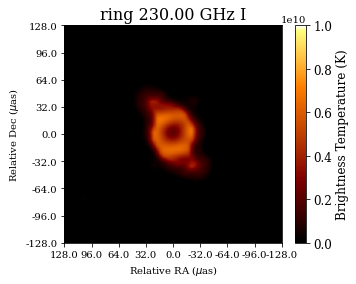

2022-07-27 16:37:28,177 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:28,178 INFO Display              :: Penalty--> 182.85357248541487
2022-07-27 16:37:28,306 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:28,308 INFO Display              :: Penalty--> 182.85357248541487
2022-07-27 16:37:28,438 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:28,440 INFO Display              :: Penalty--> 182.85357248541487
2022-07-27 16:37:28,564 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:28,565 INFO Display              :: Penalty--> 182.68809636324966
2022-07-27 16:37:28,701 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:28,703 INFO Display              :: Penalty--> 182.68809636324966
2022-07-27 16:37:28,843 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:28,845 INFO Display              :: Penalty--> 182.68809636324966
2022-07-27 16:37:29,001 INFO CountIterations      :: iteration = 7 / 2

2998.722956092229
Data Fidelity:  74.8694998339764


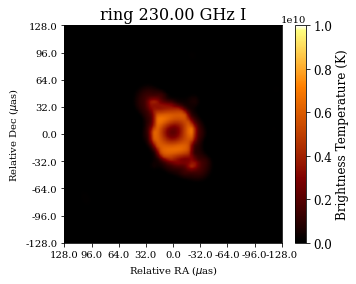

2022-07-27 16:37:31,943 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:31,945 INFO Display              :: Penalty--> 182.65745252989512
2022-07-27 16:37:32,077 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:32,079 INFO Display              :: Penalty--> 182.65745252989512
2022-07-27 16:37:32,217 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:32,219 INFO Display              :: Penalty--> 182.65745252989512
2022-07-27 16:37:32,347 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:32,349 INFO Display              :: Penalty--> 182.65745252989512
2022-07-27 16:37:32,477 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:32,479 INFO Display              :: Penalty--> 182.4919764077299
2022-07-27 16:37:32,609 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:32,610 INFO Display              :: Penalty--> 182.4919764077299
2022-07-27 16:37:32,753 INFO CountIterations      :: iteration = 7 / 25


2998.724575838955
Data Fidelity:  73.71835048984032


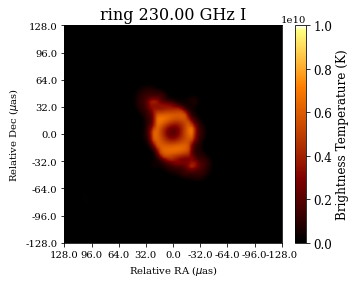

2022-07-27 16:37:35,748 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:35,750 INFO Display              :: Penalty--> 182.46133257437538
2022-07-27 16:37:35,887 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:35,889 INFO Display              :: Penalty--> 182.46133257437538
2022-07-27 16:37:36,023 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:36,025 INFO Display              :: Penalty--> 182.46133257437538
2022-07-27 16:37:36,160 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:36,161 INFO Display              :: Penalty--> 182.46133257437538
2022-07-27 16:37:36,285 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:36,286 INFO Display              :: Penalty--> 182.46133257437538
2022-07-27 16:37:36,406 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:36,407 INFO Display              :: Penalty--> 182.46133257437538
2022-07-27 16:37:36,526 INFO CountIterations      :: iteration = 7 / 2

2998.727445421191
Data Fidelity:  72.59808883788537


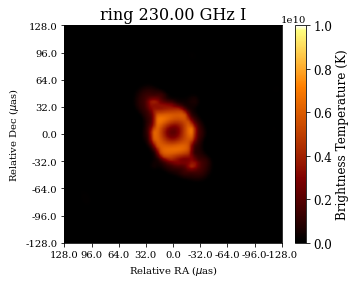

2022-07-27 16:37:39,429 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:39,432 INFO Display              :: Penalty--> 182.4000449076663
2022-07-27 16:37:39,562 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:39,564 INFO Display              :: Penalty--> 182.4000449076663
2022-07-27 16:37:39,702 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:39,704 INFO Display              :: Penalty--> 182.4000449076663
2022-07-27 16:37:39,834 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:39,836 INFO Display              :: Penalty--> 182.4000449076663
2022-07-27 16:37:39,985 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:39,987 INFO Display              :: Penalty--> 182.4000449076663
2022-07-27 16:37:40,120 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:40,122 INFO Display              :: Penalty--> 182.4000449076663
2022-07-27 16:37:40,258 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7231208574076
Data Fidelity:  71.50176931476403


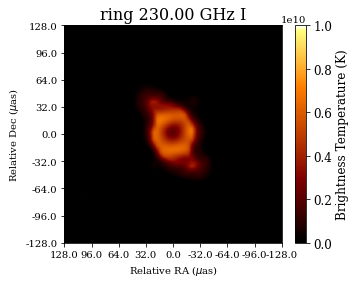

2022-07-27 16:37:43,107 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:43,108 INFO Display              :: Penalty--> 182.32803189928313
2022-07-27 16:37:43,253 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:43,255 INFO Display              :: Penalty--> 182.32803189928313
2022-07-27 16:37:43,378 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:43,379 INFO Display              :: Penalty--> 182.2973880659286
2022-07-27 16:37:43,511 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:43,514 INFO Display              :: Penalty--> 182.2973880659286
2022-07-27 16:37:43,644 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:43,646 INFO Display              :: Penalty--> 182.2973880659286
2022-07-27 16:37:43,774 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:43,776 INFO Display              :: Penalty--> 182.2973880659286
2022-07-27 16:37:43,901 INFO CountIterations      :: iteration = 7 / 25
20

2998.7064486721656
Data Fidelity:  70.43546542458058


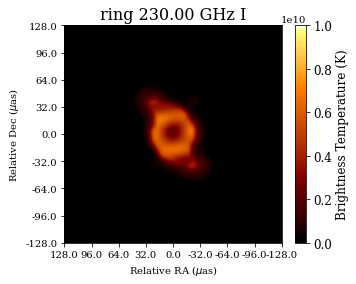

2022-07-27 16:37:46,644 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:46,645 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:46,778 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:46,780 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:46,905 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:46,907 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:47,019 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:47,021 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:47,145 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:47,146 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:47,276 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:47,277 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:47,391 INFO CountIterations      :: iteration = 7 / 2

2998.7214786385607
Data Fidelity:  69.3954823469223


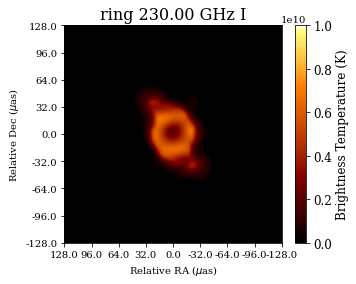

2022-07-27 16:37:50,118 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:50,120 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:50,246 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:50,248 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:50,373 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:50,374 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:50,510 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:50,512 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:50,637 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:50,639 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:50,754 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:50,756 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:50,874 INFO CountIterations      :: iteration = 7 / 2

2998.722970497004
Data Fidelity:  68.37632235714133


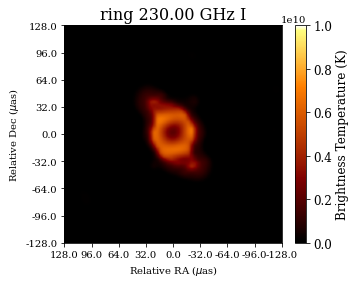

2022-07-27 16:37:53,624 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:53,626 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:53,763 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:53,764 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:53,934 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:53,936 INFO Display              :: Penalty--> 182.26674423257407
2022-07-27 16:37:54,063 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:54,065 INFO Display              :: Penalty--> 182.25601889089998
2022-07-27 16:37:54,198 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:54,199 INFO Display              :: Penalty--> 182.25601889089998
2022-07-27 16:37:54,328 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:54,330 INFO Display              :: Penalty--> 182.22537505754545
2022-07-27 16:37:54,455 INFO CountIterations      :: iteration = 7 / 2

2998.7378535952957
Data Fidelity:  67.37124035628099


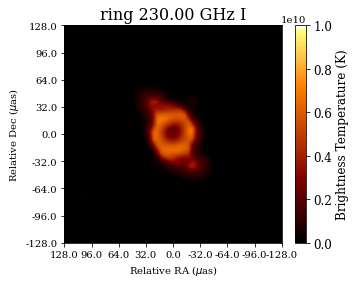

2022-07-27 16:37:57,219 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:37:57,221 INFO Display              :: Penalty--> 182.22537505754545
2022-07-27 16:37:57,356 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:37:57,358 INFO Display              :: Penalty--> 182.22537505754545
2022-07-27 16:37:57,476 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:37:57,477 INFO Display              :: Penalty--> 182.19473122419092
2022-07-27 16:37:57,613 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:37:57,614 INFO Display              :: Penalty--> 182.1640873908364
2022-07-27 16:37:57,737 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:37:57,739 INFO Display              :: Penalty--> 182.1640873908364
2022-07-27 16:37:57,875 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:37:57,877 INFO Display              :: Penalty--> 182.13344355748185
2022-07-27 16:37:58,005 INFO CountIterations      :: iteration = 7 / 25


2998.70907354304
Data Fidelity:  66.38283031618488


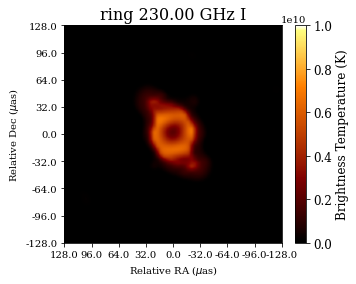

2022-07-27 16:38:00,830 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:00,832 INFO Display              :: Penalty--> 182.13344355748185
2022-07-27 16:38:00,971 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:00,972 INFO Display              :: Penalty--> 182.13344355748185
2022-07-27 16:38:01,105 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:01,107 INFO Display              :: Penalty--> 182.13344355748185
2022-07-27 16:38:01,240 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:01,242 INFO Display              :: Penalty--> 182.13344355748185
2022-07-27 16:38:01,372 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:01,374 INFO Display              :: Penalty--> 182.13344355748185
2022-07-27 16:38:01,519 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:01,521 INFO Display              :: Penalty--> 182.13344355748185
2022-07-27 16:38:01,654 INFO CountIterations      :: iteration = 7 / 2

2998.7100943999303
Data Fidelity:  65.41914456625494


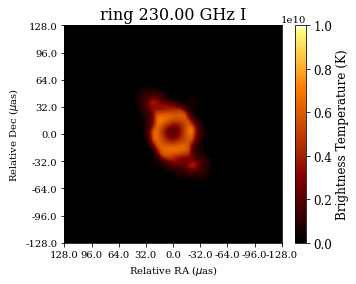

2022-07-27 16:38:04,394 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:04,395 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:04,522 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:04,524 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:04,647 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:04,649 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:04,786 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:04,788 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:04,919 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:04,921 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:05,054 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:05,056 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:05,187 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7084088990296
Data Fidelity:  64.4810847750245


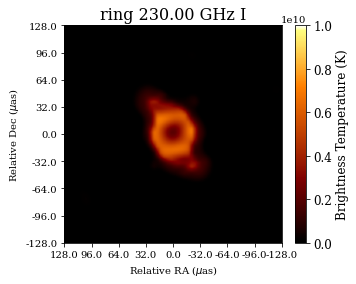

2022-07-27 16:38:08,077 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:08,079 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:08,211 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:08,213 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:08,337 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:08,340 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:08,466 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:08,468 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:08,608 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:08,610 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:08,748 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:08,750 INFO Display              :: Penalty--> 182.0721558907728
2022-07-27 16:38:08,889 INFO CountIterations      :: iteration = 7 / 25
2022

2998.7084817011855
Data Fidelity:  63.560039700726115


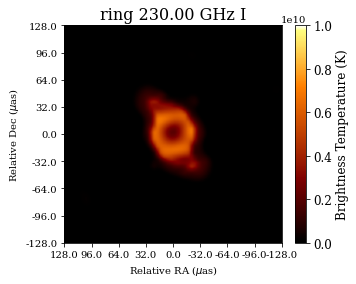

We use  6 scales with threshold 3.5
Current minimum 2756.311038463472
Start optimization with thresholds [3.5 3.5 3.5 3.5 3.5 3.5 3.5]
reverse mode: True
Updated at scale 0 to threshold 5.5 to minimum 2747.171400944969
Updated at scale 0 to threshold 6.0 to minimum 2746.701948270459
Updated at scale 0 to threshold 6.5 to minimum 2696.311027173787
Updated at scale 0 to threshold 7.0 to minimum 2670.7278722887527
Updated at scale 1 to threshold 5.5 to minimum 2613.943580479507
Updated at scale 2 to threshold 3.0 to minimum 2604.9310034735176
Updated at scale 2 to threshold 5.5 to minimum 2563.0127854941834
Updated at scale 3 to threshold 0.5 to minimum 2562.8159920241983
Updated at scale 3 to threshold 1.5 to minimum 2550.4880689797183
Updated at scale 3 to threshold 2.0 to minimum 2546.5326960132516
Updated at scale 4 to threshold 0.0 to minimum 2539.9121766909416
Updated at scale 4 to threshold 0.5 to minimum 2515.791944599783
Updated at scale 5 to threshold 0.0 to minimum 2511.8102604

2022-07-27 16:38:23,223 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:23,225 INFO Display              :: Penalty--> 517.1438607355802
2022-07-27 16:38:23,351 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:23,353 INFO Display              :: Penalty--> 485.8504665401679
2022-07-27 16:38:23,472 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:23,473 INFO Display              :: Penalty--> 479.7967922876606
2022-07-27 16:38:23,595 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:23,597 INFO Display              :: Penalty--> 473.23596606083146
2022-07-27 16:38:23,716 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:23,717 INFO Display              :: Penalty--> 468.04951171430815
2022-07-27 16:38:23,856 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:23,858 INFO Display              :: Penalty--> 463.65572614540014
2022-07-27 16:38:23,998 INFO CountIterations      :: iteration = 7 / 25
2

2877.5315619038583
Data Fidelity:  439.2873166610978


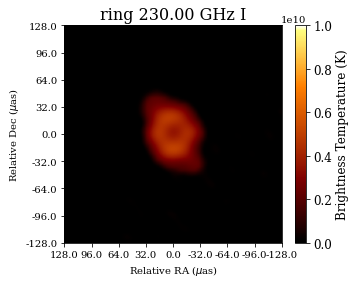

2022-07-27 16:38:26,784 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:26,785 INFO Display              :: Penalty--> 403.5649263135315
2022-07-27 16:38:26,912 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:26,914 INFO Display              :: Penalty--> 402.81109032480697
2022-07-27 16:38:27,040 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:27,041 INFO Display              :: Penalty--> 401.1808430139399
2022-07-27 16:38:27,164 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:27,165 INFO Display              :: Penalty--> 399.83711496698845
2022-07-27 16:38:27,295 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:27,297 INFO Display              :: Penalty--> 398.1762238227668
2022-07-27 16:38:27,428 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:27,429 INFO Display              :: Penalty--> 397.01942258132885
2022-07-27 16:38:27,556 INFO CountIterations      :: iteration = 7 / 25
2

2941.2387884793525
Data Fidelity:  319.27283167777614


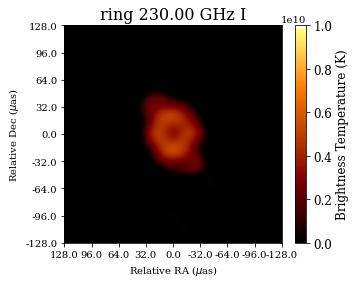

2022-07-27 16:38:30,402 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:30,404 INFO Display              :: Penalty--> 376.4809802234751
2022-07-27 16:38:30,533 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:30,535 INFO Display              :: Penalty--> 376.0887403124356
2022-07-27 16:38:30,649 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:30,652 INFO Display              :: Penalty--> 375.8926203569158
2022-07-27 16:38:30,775 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:30,777 INFO Display              :: Penalty--> 375.53255589294935
2022-07-27 16:38:30,900 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:30,902 INFO Display              :: Penalty--> 375.1602344735903
2022-07-27 16:38:31,027 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:31,029 INFO Display              :: Penalty--> 374.62243693206597
2022-07-27 16:38:31,153 INFO CountIterations      :: iteration = 7 / 25
20

2954.4347220042173
Data Fidelity:  272.25024248762475


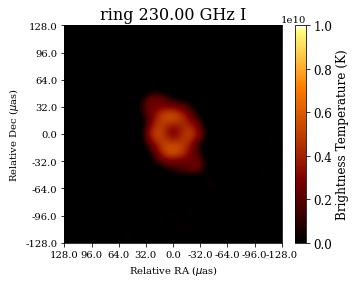

2022-07-27 16:38:33,799 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:33,801 INFO Display              :: Penalty--> 367.6034853965865
2022-07-27 16:38:33,932 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:33,934 INFO Display              :: Penalty--> 367.58203471323833
2022-07-27 16:38:34,055 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:34,056 INFO Display              :: Penalty--> 367.1484256271702
2022-07-27 16:38:34,174 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:34,176 INFO Display              :: Penalty--> 367.1484256271702
2022-07-27 16:38:34,302 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:34,303 INFO Display              :: Penalty--> 366.5789800578212
2022-07-27 16:38:34,426 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:34,428 INFO Display              :: Penalty--> 366.37213476062726
2022-07-27 16:38:34,561 INFO CountIterations      :: iteration = 7 / 25
20

2962.399615084726
Data Fidelity:  243.3446962609839


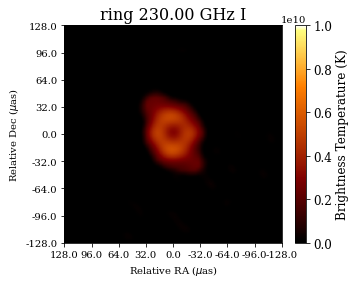

2022-07-27 16:38:37,257 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:37,259 INFO Display              :: Penalty--> 359.59579866174465
2022-07-27 16:38:37,387 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:37,388 INFO Display              :: Penalty--> 359.3996787062249
2022-07-27 16:38:37,510 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:37,512 INFO Display              :: Penalty--> 359.33839103951584
2022-07-27 16:38:37,646 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:37,648 INFO Display              :: Penalty--> 358.99671345351135
2022-07-27 16:38:37,769 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:37,770 INFO Display              :: Penalty--> 358.8005934979916
2022-07-27 16:38:37,892 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:37,894 INFO Display              :: Penalty--> 358.5738297091173
2022-07-27 16:38:38,030 INFO CountIterations      :: iteration = 7 / 25
2

2968.623327329972
Data Fidelity:  223.5913340942035


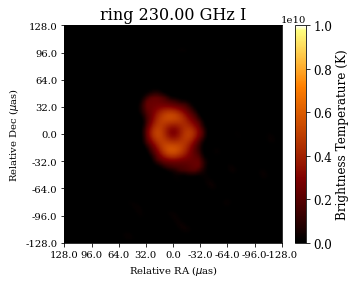

2022-07-27 16:38:40,746 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:40,748 INFO Display              :: Penalty--> 354.6882031987477
2022-07-27 16:38:40,866 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:40,868 INFO Display              :: Penalty--> 354.49208324322797
2022-07-27 16:38:40,997 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:40,999 INFO Display              :: Penalty--> 354.4307955765189
2022-07-27 16:38:41,122 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:41,124 INFO Display              :: Penalty--> 354.14274412093556
2022-07-27 16:38:41,254 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:41,255 INFO Display              :: Penalty--> 354.0600057708783
2022-07-27 16:38:41,374 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:41,376 INFO Display              :: Penalty--> 353.69840969319335
2022-07-27 16:38:41,482 INFO CountIterations      :: iteration = 7 / 25
2

2972.9076377126885
Data Fidelity:  208.57030929413668


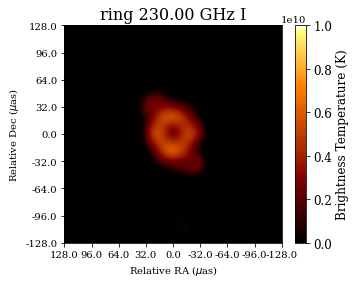

2022-07-27 16:38:44,201 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:44,202 INFO Display              :: Penalty--> 349.77294562151354
2022-07-27 16:38:44,323 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:44,324 INFO Display              :: Penalty--> 349.7622202798395
2022-07-27 16:38:44,438 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:44,440 INFO Display              :: Penalty--> 349.6702887797759
2022-07-27 16:38:44,574 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:44,576 INFO Display              :: Penalty--> 349.6702887797759
2022-07-27 16:38:44,696 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:44,698 INFO Display              :: Penalty--> 349.4940873159366
2022-07-27 16:38:44,813 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:44,815 INFO Display              :: Penalty--> 349.4940873159366
2022-07-27 16:38:44,937 INFO CountIterations      :: iteration = 7 / 25
202

2976.282974814225
Data Fidelity:  197.17057582026723


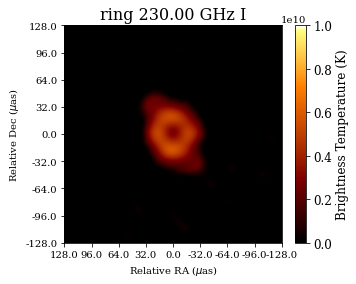

2022-07-27 16:38:47,583 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:47,585 INFO Display              :: Penalty--> 347.22032008257366
2022-07-27 16:38:47,702 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:47,704 INFO Display              :: Penalty--> 347.22032008257366
2022-07-27 16:38:47,823 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:47,825 INFO Display              :: Penalty--> 347.18967624921913
2022-07-27 16:38:47,944 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:47,947 INFO Display              :: Penalty--> 347.178950907545
2022-07-27 16:38:48,064 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:48,066 INFO Display              :: Penalty--> 347.178950907545
2022-07-27 16:38:48,185 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:48,187 INFO Display              :: Penalty--> 347.1483070741905
2022-07-27 16:38:48,319 INFO CountIterations      :: iteration = 7 / 25
202

2978.9204948901606
Data Fidelity:  188.09578889340267


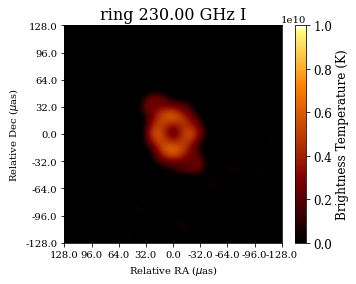

2022-07-27 16:38:50,983 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:50,985 INFO Display              :: Penalty--> 345.73562982424204
2022-07-27 16:38:51,118 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:51,120 INFO Display              :: Penalty--> 345.70498599088756
2022-07-27 16:38:51,230 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:51,232 INFO Display              :: Penalty--> 345.5395098687223
2022-07-27 16:38:51,352 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:51,354 INFO Display              :: Penalty--> 345.37403374655713
2022-07-27 16:38:51,481 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:51,483 INFO Display              :: Penalty--> 345.37403374655713
2022-07-27 16:38:51,603 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:51,605 INFO Display              :: Penalty--> 345.37403374655713
2022-07-27 16:38:51,727 INFO CountIterations      :: iteration = 7 / 25

2981.0116222739452
Data Fidelity:  180.40129675789993


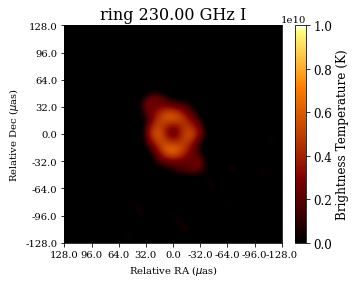

2022-07-27 16:38:54,407 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:54,408 INFO Display              :: Penalty--> 343.7912843773895
2022-07-27 16:38:54,526 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:54,528 INFO Display              :: Penalty--> 343.7912843773895
2022-07-27 16:38:54,643 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:54,645 INFO Display              :: Penalty--> 343.7912843773895
2022-07-27 16:38:54,761 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:54,763 INFO Display              :: Penalty--> 343.78362341905085
2022-07-27 16:38:54,884 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:54,886 INFO Display              :: Penalty--> 343.78362341905085
2022-07-27 16:38:55,017 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:55,019 INFO Display              :: Penalty--> 343.7529795856963
2022-07-27 16:38:55,123 INFO CountIterations      :: iteration = 7 / 25
20

2982.779511905118
Data Fidelity:  173.774980932578


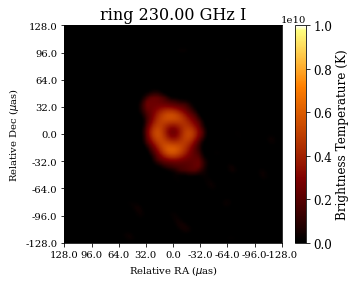

2022-07-27 16:38:57,802 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:38:57,804 INFO Display              :: Penalty--> 342.07063833607583
2022-07-27 16:38:57,928 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:38:57,930 INFO Display              :: Penalty--> 342.0399945027213
2022-07-27 16:38:58,041 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:38:58,043 INFO Display              :: Penalty--> 342.00935066936677
2022-07-27 16:38:58,162 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:38:58,165 INFO Display              :: Penalty--> 341.97870683601224
2022-07-27 16:38:58,295 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:38:58,297 INFO Display              :: Penalty--> 341.9174191693032
2022-07-27 16:38:58,426 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:38:58,428 INFO Display              :: Penalty--> 341.9174191693032
2022-07-27 16:38:58,551 INFO CountIterations      :: iteration = 7 / 25
2

2984.3543038749335
Data Fidelity:  167.94185097977157


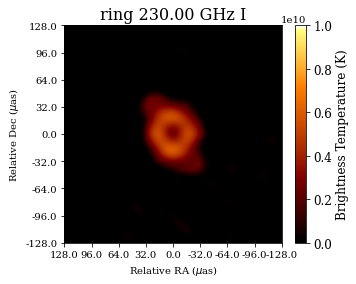

2022-07-27 16:39:01,308 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:01,310 INFO Display              :: Penalty--> 340.7529563915772
2022-07-27 16:39:01,438 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:01,440 INFO Display              :: Penalty--> 340.74529543323854
2022-07-27 16:39:01,565 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:01,566 INFO Display              :: Penalty--> 340.65336393317494
2022-07-27 16:39:01,693 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:01,695 INFO Display              :: Penalty--> 340.6426385915008
2022-07-27 16:39:01,812 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:01,814 INFO Display              :: Penalty--> 340.4771624693356
2022-07-27 16:39:01,937 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:01,939 INFO Display              :: Penalty--> 340.46643712766155
2022-07-27 16:39:02,060 INFO CountIterations      :: iteration = 7 / 25
2

2985.548648509328
Data Fidelity:  162.75810571788003


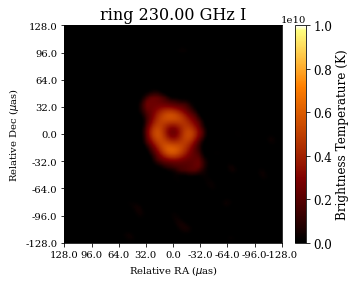

2022-07-27 16:39:04,723 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:04,724 INFO Display              :: Penalty--> 339.7141327526555
2022-07-27 16:39:04,849 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:04,851 INFO Display              :: Penalty--> 339.5379312888162
2022-07-27 16:39:04,979 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:04,980 INFO Display              :: Penalty--> 339.34181133329645
2022-07-27 16:39:05,097 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:05,099 INFO Display              :: Penalty--> 339.3111674999419
2022-07-27 16:39:05,221 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:05,223 INFO Display              :: Penalty--> 339.3111674999419
2022-07-27 16:39:05,344 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:05,345 INFO Display              :: Penalty--> 338.949571422257
2022-07-27 16:39:05,479 INFO CountIterations      :: iteration = 7 / 25
2022

2986.653470088606
Data Fidelity:  157.79587448742905


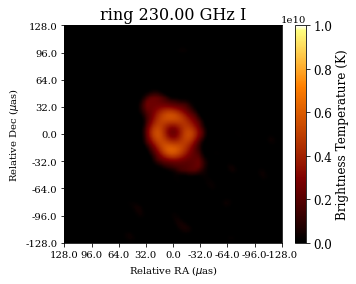

2022-07-27 16:39:08,148 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:08,150 INFO Display              :: Penalty--> 337.196749355921
2022-07-27 16:39:08,272 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:08,274 INFO Display              :: Penalty--> 336.86579711159055
2022-07-27 16:39:08,408 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:08,410 INFO Display              :: Penalty--> 336.86579711159055
2022-07-27 16:39:08,531 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:08,533 INFO Display              :: Penalty--> 336.86579711159055
2022-07-27 16:39:08,652 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:08,653 INFO Display              :: Penalty--> 336.68959564775133
2022-07-27 16:39:08,792 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:08,794 INFO Display              :: Penalty--> 336.68959564775133
2022-07-27 16:39:08,923 INFO CountIterations      :: iteration = 7 / 25


2987.3526281744325
Data Fidelity:  153.05058123966057


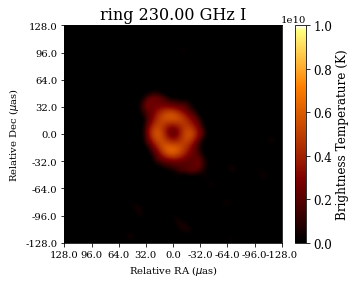

2022-07-27 16:39:11,812 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:11,814 INFO Display              :: Penalty--> 335.5128759146329
2022-07-27 16:39:11,940 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:11,942 INFO Display              :: Penalty--> 335.4822320812783
2022-07-27 16:39:12,064 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:12,066 INFO Display              :: Penalty--> 335.4515882479238
2022-07-27 16:39:12,196 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:12,198 INFO Display              :: Penalty--> 335.4515882479238
2022-07-27 16:39:12,319 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:12,321 INFO Display              :: Penalty--> 335.2248244590495
2022-07-27 16:39:12,435 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:12,437 INFO Display              :: Penalty--> 335.2248244590495
2022-07-27 16:39:12,557 INFO CountIterations      :: iteration = 7 / 25
2022

2988.227742089796
Data Fidelity:  147.9484553606937


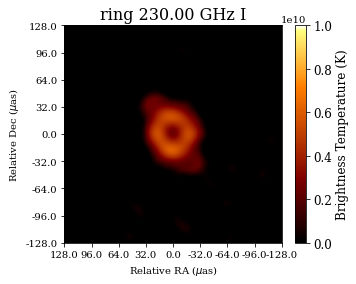

2022-07-27 16:39:15,213 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:15,216 INFO Display              :: Penalty--> 333.39079681227327
2022-07-27 16:39:15,340 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:15,342 INFO Display              :: Penalty--> 333.36015297891873
2022-07-27 16:39:15,459 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:15,461 INFO Display              :: Penalty--> 333.3295091455642
2022-07-27 16:39:15,583 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:15,585 INFO Display              :: Penalty--> 333.29886531220967
2022-07-27 16:39:15,703 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:15,705 INFO Display              :: Penalty--> 333.29886531220967
2022-07-27 16:39:15,822 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:15,824 INFO Display              :: Penalty--> 333.29886531220967
2022-07-27 16:39:15,933 INFO CountIterations      :: iteration = 7 / 25

2988.546369552283
Data Fidelity:  141.1105745554333


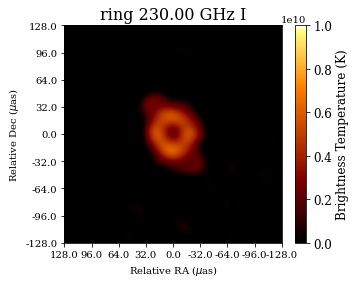

2022-07-27 16:39:18,605 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:18,608 INFO Display              :: Penalty--> 331.98578052066347
2022-07-27 16:39:18,730 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:18,732 INFO Display              :: Penalty--> 331.82030439849825
2022-07-27 16:39:18,851 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:18,853 INFO Display              :: Penalty--> 331.65482827633303
2022-07-27 16:39:18,976 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:18,978 INFO Display              :: Penalty--> 331.3238760320026
2022-07-27 16:39:19,093 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:19,095 INFO Display              :: Penalty--> 331.3238760320026
2022-07-27 16:39:19,217 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:19,219 INFO Display              :: Penalty--> 331.29323219864807
2022-07-27 16:39:19,345 INFO CountIterations      :: iteration = 7 / 25


2988.6257412826635
Data Fidelity:  122.93522195104761


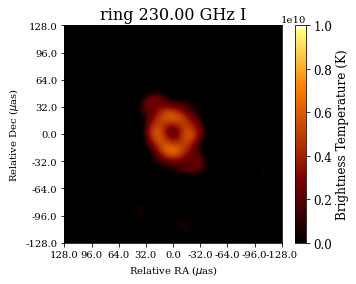

2022-07-27 16:39:21,969 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:21,971 INFO Display              :: Penalty--> 328.2043430436993
2022-07-27 16:39:22,091 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:22,092 INFO Display              :: Penalty--> 327.83202162434026
2022-07-27 16:39:22,214 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:22,216 INFO Display              :: Penalty--> 327.59453249379186
2022-07-27 16:39:22,332 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:22,334 INFO Display              :: Penalty--> 327.39841253827217
2022-07-27 16:39:22,455 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:22,457 INFO Display              :: Penalty--> 327.20229258275236
2022-07-27 16:39:22,588 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:22,590 INFO Display              :: Penalty--> 327.17164874939783
2022-07-27 16:39:22,708 INFO CountIterations      :: iteration = 7 / 25

2988.774456347468
Data Fidelity:  91.26533105836421


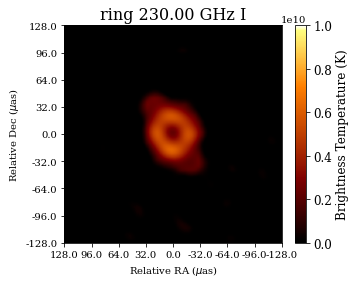

2022-07-27 16:39:25,374 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:25,376 INFO Display              :: Penalty--> 323.226266763987
2022-07-27 16:39:25,505 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:25,508 INFO Display              :: Penalty--> 322.864670686302
2022-07-27 16:39:25,634 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:25,637 INFO Display              :: Penalty--> 322.5337184419716
2022-07-27 16:39:25,756 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:25,758 INFO Display              :: Penalty--> 322.1721223642866
2022-07-27 16:39:25,868 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:25,869 INFO Display              :: Penalty--> 322.11083469757756
2022-07-27 16:39:25,980 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:25,982 INFO Display              :: Penalty--> 321.6144063310819
2022-07-27 16:39:26,107 INFO CountIterations      :: iteration = 7 / 25
2022-

2989.8830816133955
Data Fidelity:  76.82391229690717


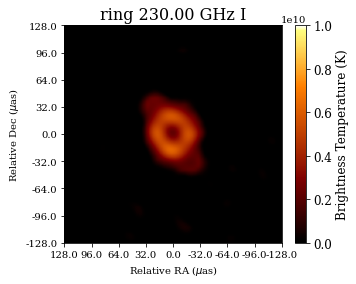

2022-07-27 16:39:28,756 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:28,758 INFO Display              :: Penalty--> 319.64094924254255
2022-07-27 16:39:28,870 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:28,872 INFO Display              :: Penalty--> 319.47547312037733
2022-07-27 16:39:28,988 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:28,990 INFO Display              :: Penalty--> 319.4448292870228
2022-07-27 16:39:29,100 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:29,102 INFO Display              :: Penalty--> 319.41418545366827
2022-07-27 16:39:29,221 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:29,222 INFO Display              :: Penalty--> 319.38354162031374
2022-07-27 16:39:29,346 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:29,347 INFO Display              :: Penalty--> 319.3528977869592
2022-07-27 16:39:29,467 INFO CountIterations      :: iteration = 7 / 25


2990.4302664287015
Data Fidelity:  68.64180487907423


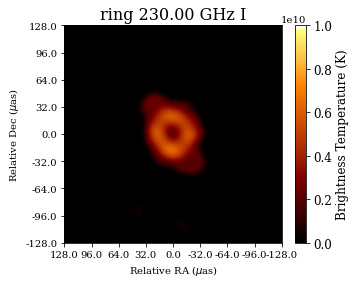

2022-07-27 16:39:32,101 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:32,104 INFO Display              :: Penalty--> 316.6439910097081
2022-07-27 16:39:32,254 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:32,255 INFO Display              :: Penalty--> 316.6439910097081
2022-07-27 16:39:32,387 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:32,389 INFO Display              :: Penalty--> 316.4785148875429
2022-07-27 16:39:32,501 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:32,503 INFO Display              :: Penalty--> 316.44787105418834
2022-07-27 16:39:32,621 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:32,623 INFO Display              :: Penalty--> 316.4172272208338
2022-07-27 16:39:32,740 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:32,741 INFO Display              :: Penalty--> 316.2211072653141
2022-07-27 16:39:32,863 INFO CountIterations      :: iteration = 7 / 25
202

2990.740228372554
Data Fidelity:  62.99877034488591


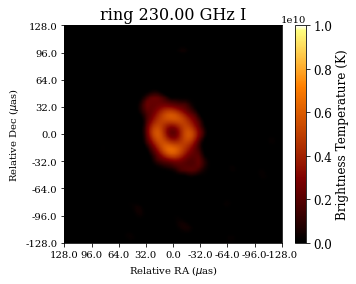

2022-07-27 16:39:35,562 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:35,564 INFO Display              :: Penalty--> 314.563280504428
2022-07-27 16:39:35,678 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:35,680 INFO Display              :: Penalty--> 314.39780438226273
2022-07-27 16:39:35,808 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:35,810 INFO Display              :: Penalty--> 314.35949959056956
2022-07-27 16:39:35,942 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:35,944 INFO Display              :: Penalty--> 314.328855757215
2022-07-27 16:39:36,059 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:36,061 INFO Display              :: Penalty--> 314.16337963504986
2022-07-27 16:39:36,181 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:36,182 INFO Display              :: Penalty--> 314.16337963504986
2022-07-27 16:39:36,311 INFO CountIterations      :: iteration = 7 / 25
20

2990.9680919934863
Data Fidelity:  58.619714208428135


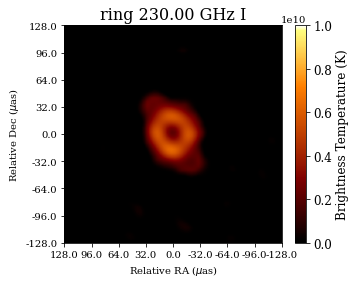

2022-07-27 16:39:39,054 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:39,055 INFO Display              :: Penalty--> 312.48256999914776
2022-07-27 16:39:39,181 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:39,183 INFO Display              :: Penalty--> 312.4519261657932
2022-07-27 16:39:39,306 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:39,308 INFO Display              :: Penalty--> 312.4519261657932
2022-07-27 16:39:39,426 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:39,428 INFO Display              :: Penalty--> 312.4519261657932
2022-07-27 16:39:39,551 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:39,553 INFO Display              :: Penalty--> 312.27878908528936
2022-07-27 16:39:39,684 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:39,686 INFO Display              :: Penalty--> 312.27878908528936
2022-07-27 16:39:39,804 INFO CountIterations      :: iteration = 7 / 25
2

2991.2437716244376
Data Fidelity:  55.04160196229789


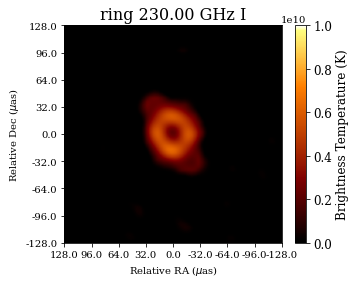

2022-07-27 16:39:42,464 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:42,465 INFO Display              :: Penalty--> 311.15722825220905
2022-07-27 16:39:42,595 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:42,597 INFO Display              :: Penalty--> 310.99175213004384
2022-07-27 16:39:42,716 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:42,718 INFO Display              :: Penalty--> 310.99175213004384
2022-07-27 16:39:42,838 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:42,840 INFO Display              :: Penalty--> 310.9611082966893
2022-07-27 16:39:42,961 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:42,963 INFO Display              :: Penalty--> 310.9611082966893
2022-07-27 16:39:43,085 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:43,086 INFO Display              :: Penalty--> 310.9611082966893
2022-07-27 16:39:43,198 INFO CountIterations      :: iteration = 7 / 25
2

2991.551765274519
Data Fidelity:  51.882772741428234


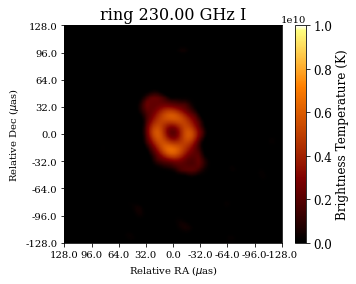

2022-07-27 16:39:45,895 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:45,897 INFO Display              :: Penalty--> 309.66334542182034
2022-07-27 16:39:46,017 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:46,019 INFO Display              :: Penalty--> 309.66334542182034
2022-07-27 16:39:46,141 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:46,142 INFO Display              :: Penalty--> 309.66334542182034
2022-07-27 16:39:46,271 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:46,273 INFO Display              :: Penalty--> 309.66334542182034
2022-07-27 16:39:46,399 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:46,400 INFO Display              :: Penalty--> 309.4978692996551
2022-07-27 16:39:46,520 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:46,522 INFO Display              :: Penalty--> 309.32166783581584
2022-07-27 16:39:46,645 INFO CountIterations      :: iteration = 7 / 25

2991.803427373365
Data Fidelity:  49.12509072080185


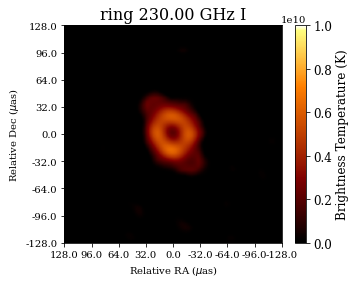

2022-07-27 16:39:49,429 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:49,431 INFO Display              :: Penalty--> 308.2460727527673
2022-07-27 16:39:49,576 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:49,578 INFO Display              :: Penalty--> 308.2460727527673
2022-07-27 16:39:49,704 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:49,706 INFO Display              :: Penalty--> 308.2460727527673
2022-07-27 16:39:49,833 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:49,834 INFO Display              :: Penalty--> 308.2460727527673
2022-07-27 16:39:49,961 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:49,963 INFO Display              :: Penalty--> 308.2154289194128
2022-07-27 16:39:50,097 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:50,099 INFO Display              :: Penalty--> 308.18478508605824
2022-07-27 16:39:50,231 INFO CountIterations      :: iteration = 7 / 25
202

2992.1160590504624
Data Fidelity:  46.67751537271258


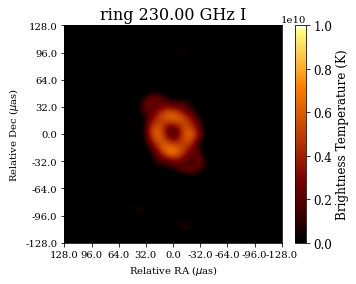

2022-07-27 16:39:53,099 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:53,101 INFO Display              :: Penalty--> 307.55505604447035
2022-07-27 16:39:53,217 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:53,219 INFO Display              :: Penalty--> 307.5244122111158
2022-07-27 16:39:53,347 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:53,348 INFO Display              :: Penalty--> 307.5244122111158
2022-07-27 16:39:53,530 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:53,532 INFO Display              :: Penalty--> 307.5244122111158
2022-07-27 16:39:53,660 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:53,662 INFO Display              :: Penalty--> 307.34821074727654
2022-07-27 16:39:53,798 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:53,799 INFO Display              :: Penalty--> 307.30684157224795
2022-07-27 16:39:53,923 INFO CountIterations      :: iteration = 7 / 25
2

2992.3795173577882
Data Fidelity:  44.39548516948966


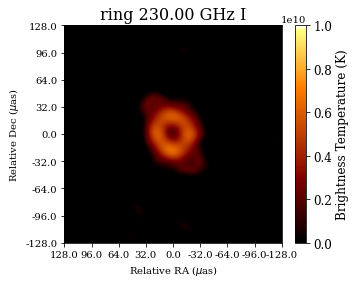

2022-07-27 16:39:56,665 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:39:56,668 INFO Display              :: Penalty--> 306.64646869730547
2022-07-27 16:39:56,794 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:39:56,796 INFO Display              :: Penalty--> 306.61582486395093
2022-07-27 16:39:56,940 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:39:56,942 INFO Display              :: Penalty--> 306.61582486395093
2022-07-27 16:39:57,086 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:39:57,088 INFO Display              :: Penalty--> 306.4503487417857
2022-07-27 16:39:57,208 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:39:57,210 INFO Display              :: Penalty--> 306.4503487417857
2022-07-27 16:39:57,353 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:39:57,355 INFO Display              :: Penalty--> 306.4503487417857
2022-07-27 16:39:57,480 INFO CountIterations      :: iteration = 7 / 25
2

2992.6961422144627
Data Fidelity:  42.3576499223888


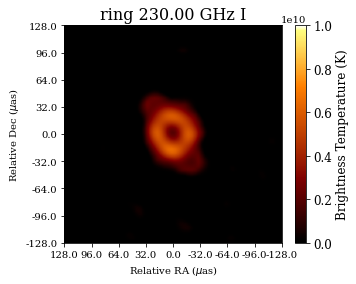

2022-07-27 16:40:00,195 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:00,200 INFO Display              :: Penalty--> 305.92480815565403
2022-07-27 16:40:00,387 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:00,389 INFO Display              :: Penalty--> 305.92480815565403
2022-07-27 16:40:00,551 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:00,553 INFO Display              :: Penalty--> 305.92480815565403
2022-07-27 16:40:00,716 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:00,718 INFO Display              :: Penalty--> 305.92480815565403
2022-07-27 16:40:00,834 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:00,835 INFO Display              :: Penalty--> 305.8941643222995
2022-07-27 16:40:00,969 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:00,970 INFO Display              :: Penalty--> 305.8941643222995
2022-07-27 16:40:01,084 INFO CountIterations      :: iteration = 7 / 25


2993.014445314142
Data Fidelity:  40.47321332502908


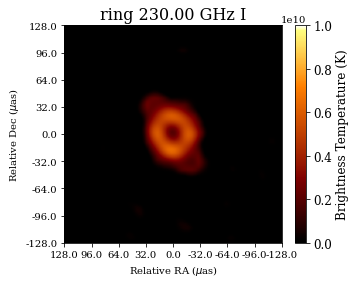

2022-07-27 16:40:04,948 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:04,951 INFO Display              :: Penalty--> 305.53256824461454
2022-07-27 16:40:05,071 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:05,073 INFO Display              :: Penalty--> 305.53256824461454
2022-07-27 16:40:05,197 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:05,199 INFO Display              :: Penalty--> 305.5218429029404
2022-07-27 16:40:05,311 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:05,313 INFO Display              :: Penalty--> 305.5218429029404
2022-07-27 16:40:05,449 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:05,450 INFO Display              :: Penalty--> 305.5218429029404
2022-07-27 16:40:05,567 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:05,570 INFO Display              :: Penalty--> 305.5218429029404
2022-07-27 16:40:05,690 INFO CountIterations      :: iteration = 7 / 25
20

2993.3019096026223
Data Fidelity:  38.722535049338276


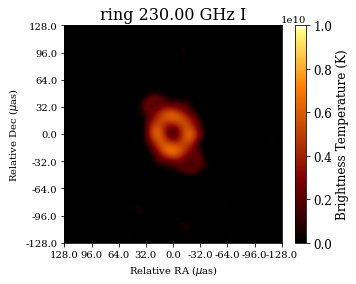

2022-07-27 16:40:08,439 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:08,441 INFO Display              :: Penalty--> 305.14186052524275
2022-07-27 16:40:08,625 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:08,628 INFO Display              :: Penalty--> 305.14186052524275
2022-07-27 16:40:08,754 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:08,756 INFO Display              :: Penalty--> 305.14186052524275
2022-07-27 16:40:08,874 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:08,877 INFO Display              :: Penalty--> 305.14186052524275
2022-07-27 16:40:08,997 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:08,999 INFO Display              :: Penalty--> 304.97638440307753
2022-07-27 16:40:09,119 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:09,120 INFO Display              :: Penalty--> 304.97638440307753
2022-07-27 16:40:09,248 INFO CountIterations      :: iteration = 7 / 2

2993.5594983065453
Data Fidelity:  37.009367553463505


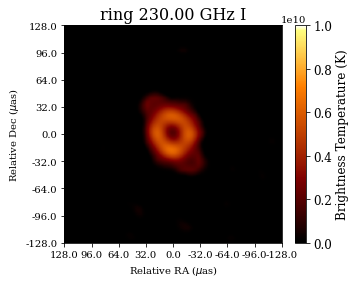

2022-07-27 16:40:11,911 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:11,914 INFO Display              :: Penalty--> 303.9850592838046
2022-07-27 16:40:12,043 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:12,045 INFO Display              :: Penalty--> 303.9850592838046
2022-07-27 16:40:12,153 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:12,155 INFO Display              :: Penalty--> 303.9850592838046
2022-07-27 16:40:12,283 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:12,285 INFO Display              :: Penalty--> 303.9544154504501
2022-07-27 16:40:12,405 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:12,406 INFO Display              :: Penalty--> 303.7889393282849
2022-07-27 16:40:12,516 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:12,518 INFO Display              :: Penalty--> 303.7889393282849
2022-07-27 16:40:12,642 INFO CountIterations      :: iteration = 7 / 25
2022

2993.7582834027244
Data Fidelity:  35.463110707827255


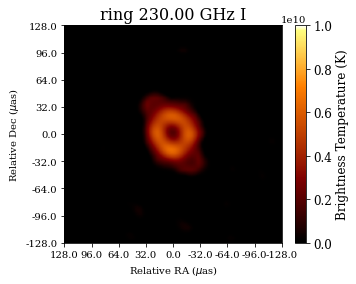

2022-07-27 16:40:15,247 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:15,248 INFO Display              :: Penalty--> 303.35533024221684
2022-07-27 16:40:15,361 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:15,363 INFO Display              :: Penalty--> 303.35533024221684
2022-07-27 16:40:15,479 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:15,481 INFO Display              :: Penalty--> 303.3246864088623
2022-07-27 16:40:15,606 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:15,608 INFO Display              :: Penalty--> 303.3246864088623
2022-07-27 16:40:15,735 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:15,737 INFO Display              :: Penalty--> 303.1285664533425
2022-07-27 16:40:15,861 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:15,862 INFO Display              :: Penalty--> 303.1285664533425
2022-07-27 16:40:15,985 INFO CountIterations      :: iteration = 7 / 25
20

2994.0540324928597
Data Fidelity:  33.98067961541783


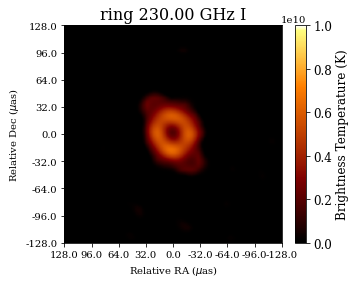

2022-07-27 16:40:18,633 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:18,634 INFO Display              :: Penalty--> 302.42682440337154
2022-07-27 16:40:18,774 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:18,775 INFO Display              :: Penalty--> 302.42682440337154
2022-07-27 16:40:18,890 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:18,892 INFO Display              :: Penalty--> 302.42682440337154
2022-07-27 16:40:19,014 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:19,016 INFO Display              :: Penalty--> 302.42682440337154
2022-07-27 16:40:19,136 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:19,138 INFO Display              :: Penalty--> 302.396180570017
2022-07-27 16:40:19,255 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:19,256 INFO Display              :: Penalty--> 302.396180570017
2022-07-27 16:40:19,377 INFO CountIterations      :: iteration = 7 / 25
20

2994.2174916448485
Data Fidelity:  32.63159305447597


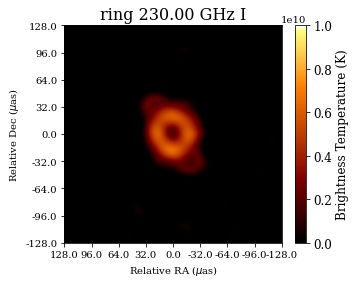

2022-07-27 16:40:22,093 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:22,095 INFO Display              :: Penalty--> 302.12804760611397
2022-07-27 16:40:22,223 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:22,225 INFO Display              :: Penalty--> 302.12804760611397
2022-07-27 16:40:22,344 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:22,346 INFO Display              :: Penalty--> 302.12804760611397
2022-07-27 16:40:22,470 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:22,472 INFO Display              :: Penalty--> 302.12804760611397
2022-07-27 16:40:22,589 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:22,590 INFO Display              :: Penalty--> 302.12804760611397
2022-07-27 16:40:22,725 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:22,727 INFO Display              :: Penalty--> 301.9625714839488
2022-07-27 16:40:22,848 INFO CountIterations      :: iteration = 7 / 25

2994.451247667129
Data Fidelity:  31.37132043662065


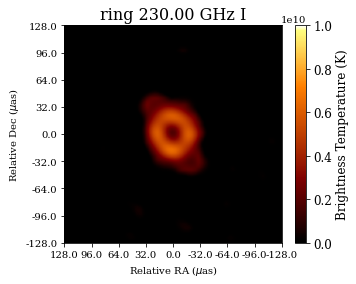

2022-07-27 16:40:25,619 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:25,621 INFO Display              :: Penalty--> 301.9135413505816
2022-07-27 16:40:25,754 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:25,756 INFO Display              :: Penalty--> 301.9135413505816
2022-07-27 16:40:25,880 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:25,882 INFO Display              :: Penalty--> 301.9135413505816
2022-07-27 16:40:26,012 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:26,014 INFO Display              :: Penalty--> 301.9135413505816
2022-07-27 16:40:26,145 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:26,147 INFO Display              :: Penalty--> 301.9135413505816
2022-07-27 16:40:26,266 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:26,268 INFO Display              :: Penalty--> 301.9135413505816
2022-07-27 16:40:26,395 INFO CountIterations      :: iteration = 7 / 25
2022

2994.6718643530075
Data Fidelity:  30.178569048330104


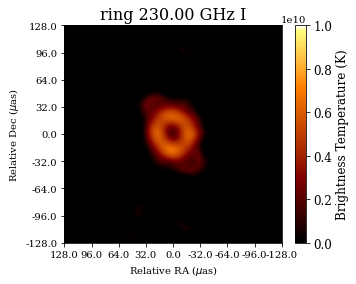

2022-07-27 16:40:29,196 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:29,198 INFO Display              :: Penalty--> 301.6852453700395
2022-07-27 16:40:29,321 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:29,323 INFO Display              :: Penalty--> 301.6852453700395
2022-07-27 16:40:29,445 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:29,446 INFO Display              :: Penalty--> 301.6852453700395
2022-07-27 16:40:29,570 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:29,571 INFO Display              :: Penalty--> 301.6852453700395
2022-07-27 16:40:29,688 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:29,690 INFO Display              :: Penalty--> 301.6852453700395
2022-07-27 16:40:29,818 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:29,820 INFO Display              :: Penalty--> 301.6852453700395
2022-07-27 16:40:29,950 INFO CountIterations      :: iteration = 7 / 25
2022

2994.9046616994665
Data Fidelity:  29.04139953501042


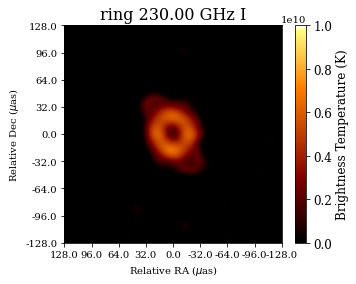

2022-07-27 16:40:32,707 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:32,708 INFO Display              :: Penalty--> 301.4584815811653
2022-07-27 16:40:32,849 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:32,850 INFO Display              :: Penalty--> 301.4584815811653
2022-07-27 16:40:32,986 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:32,987 INFO Display              :: Penalty--> 301.4584815811653
2022-07-27 16:40:33,121 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:33,123 INFO Display              :: Penalty--> 301.4584815811653
2022-07-27 16:40:33,254 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:33,255 INFO Display              :: Penalty--> 301.4584815811653
2022-07-27 16:40:33,394 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:33,395 INFO Display              :: Penalty--> 301.4584815811653
2022-07-27 16:40:33,535 INFO CountIterations      :: iteration = 7 / 25
2022

2995.1214609345066
Data Fidelity:  27.948470236423965


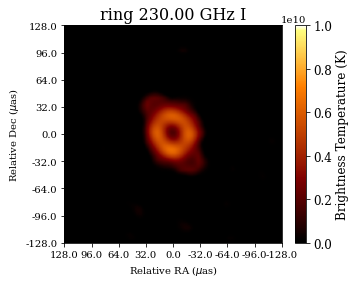

2022-07-27 16:40:36,628 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:36,630 INFO Display              :: Penalty--> 300.92068403964106
2022-07-27 16:40:36,765 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:36,767 INFO Display              :: Penalty--> 300.92068403964106
2022-07-27 16:40:36,895 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:36,897 INFO Display              :: Penalty--> 300.92068403964106
2022-07-27 16:40:37,023 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:37,024 INFO Display              :: Penalty--> 300.92068403964106
2022-07-27 16:40:37,144 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:37,146 INFO Display              :: Penalty--> 300.92068403964106
2022-07-27 16:40:37,267 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:37,268 INFO Display              :: Penalty--> 300.92068403964106
2022-07-27 16:40:37,390 INFO CountIterations      :: iteration = 7 / 2

2995.2687944726604
Data Fidelity:  26.924292692750903


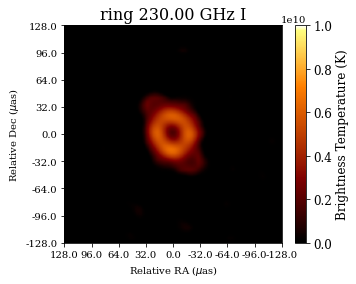

2022-07-27 16:40:40,113 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:40,114 INFO Display              :: Penalty--> 300.62497162571907
2022-07-27 16:40:40,227 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:40,229 INFO Display              :: Penalty--> 300.62497162571907
2022-07-27 16:40:40,344 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:40,346 INFO Display              :: Penalty--> 300.61424628404495
2022-07-27 16:40:40,471 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:40,472 INFO Display              :: Penalty--> 300.61424628404495
2022-07-27 16:40:40,583 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:40,586 INFO Display              :: Penalty--> 300.61424628404495
2022-07-27 16:40:40,728 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:40,729 INFO Display              :: Penalty--> 300.61424628404495
2022-07-27 16:40:40,855 INFO CountIterations      :: iteration = 7 / 2

2995.3886526911715
Data Fidelity:  25.948680424216484


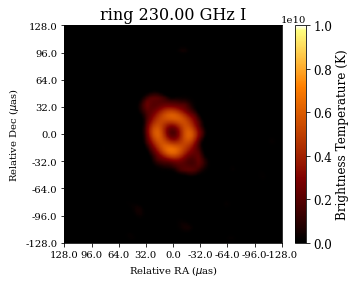

2022-07-27 16:40:43,477 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:43,479 INFO Display              :: Penalty--> 300.0458049091662
2022-07-27 16:40:43,590 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:43,592 INFO Display              :: Penalty--> 300.0458049091662
2022-07-27 16:40:43,722 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:43,725 INFO Display              :: Penalty--> 300.0350795674921
2022-07-27 16:40:43,850 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:43,852 INFO Display              :: Penalty--> 300.0350795674921
2022-07-27 16:40:43,974 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:43,975 INFO Display              :: Penalty--> 300.0350795674921
2022-07-27 16:40:44,087 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:44,089 INFO Display              :: Penalty--> 300.0350795674921
2022-07-27 16:40:44,232 INFO CountIterations      :: iteration = 7 / 25
2022

2995.607221289527
Data Fidelity:  25.032954207909754


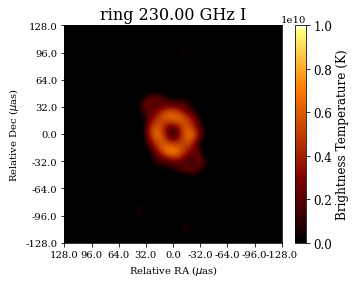

2022-07-27 16:40:46,884 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:46,887 INFO Display              :: Penalty--> 299.66275814813304
2022-07-27 16:40:47,017 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:47,019 INFO Display              :: Penalty--> 299.652032806459
2022-07-27 16:40:47,134 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:47,136 INFO Display              :: Penalty--> 299.48655668429376
2022-07-27 16:40:47,259 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:47,261 INFO Display              :: Penalty--> 299.48655668429376
2022-07-27 16:40:47,372 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:47,374 INFO Display              :: Penalty--> 299.48655668429376
2022-07-27 16:40:47,496 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:47,498 INFO Display              :: Penalty--> 299.48655668429376
2022-07-27 16:40:47,628 INFO CountIterations      :: iteration = 7 / 25


2995.667499639412
Data Fidelity:  24.16777916718366


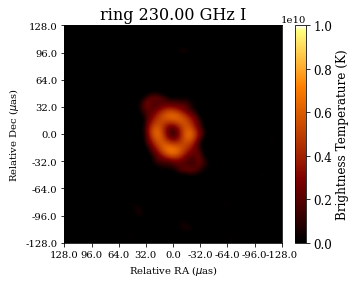

2022-07-27 16:40:50,350 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:50,352 INFO Display              :: Penalty--> 299.24906755374536
2022-07-27 16:40:50,480 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:50,482 INFO Display              :: Penalty--> 299.2414065954067
2022-07-27 16:40:50,589 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:50,591 INFO Display              :: Penalty--> 299.23374563706807
2022-07-27 16:40:50,715 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:50,716 INFO Display              :: Penalty--> 299.23374563706807
2022-07-27 16:40:50,850 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:50,852 INFO Display              :: Penalty--> 299.23374563706807
2022-07-27 16:40:50,962 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:50,963 INFO Display              :: Penalty--> 299.06826951490285
2022-07-27 16:40:51,101 INFO CountIterations      :: iteration = 7 / 25

2995.8005744724833
Data Fidelity:  23.33698027195385


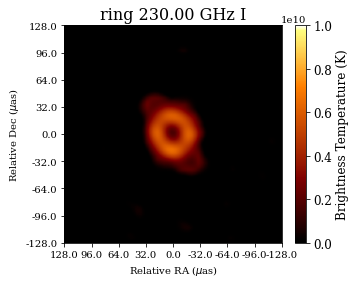

2022-07-27 16:40:53,828 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:53,829 INFO Display              :: Penalty--> 298.86142421770904
2022-07-27 16:40:53,950 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:53,952 INFO Display              :: Penalty--> 298.86142421770904
2022-07-27 16:40:54,072 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:54,074 INFO Display              :: Penalty--> 298.86142421770904
2022-07-27 16:40:54,198 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:54,200 INFO Display              :: Penalty--> 298.86142421770904
2022-07-27 16:40:54,330 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:54,332 INFO Display              :: Penalty--> 298.6959480955438
2022-07-27 16:40:54,447 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:54,448 INFO Display              :: Penalty--> 298.6959480955438
2022-07-27 16:40:54,572 INFO CountIterations      :: iteration = 7 / 25


2995.8996278858194
Data Fidelity:  22.557156075684375


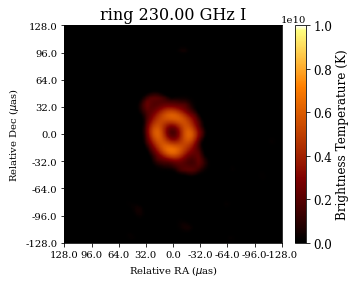

2022-07-27 16:40:57,264 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:40:57,265 INFO Display              :: Penalty--> 298.5197466317045
2022-07-27 16:40:57,399 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:40:57,401 INFO Display              :: Penalty--> 298.5197466317045
2022-07-27 16:40:57,517 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:40:57,520 INFO Display              :: Penalty--> 298.5197466317045
2022-07-27 16:40:57,634 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:40:57,635 INFO Display              :: Penalty--> 298.5197466317045
2022-07-27 16:40:57,755 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:40:57,757 INFO Display              :: Penalty--> 298.5197466317045
2022-07-27 16:40:57,878 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:40:57,880 INFO Display              :: Penalty--> 298.5197466317045
2022-07-27 16:40:57,992 INFO CountIterations      :: iteration = 7 / 25
2022

2996.050600396829
Data Fidelity:  21.820398522192512


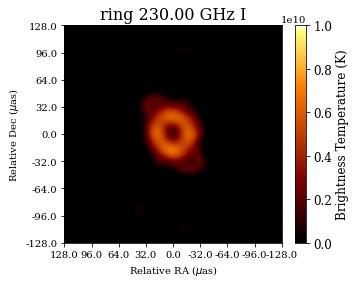

2022-07-27 16:41:00,717 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:00,719 INFO Display              :: Penalty--> 298.3680596565995
2022-07-27 16:41:00,841 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:00,843 INFO Display              :: Penalty--> 298.3680596565995
2022-07-27 16:41:00,962 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:00,964 INFO Display              :: Penalty--> 298.3680596565995
2022-07-27 16:41:01,087 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:01,089 INFO Display              :: Penalty--> 298.3680596565995
2022-07-27 16:41:01,214 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:01,216 INFO Display              :: Penalty--> 298.20258353443427
2022-07-27 16:41:01,337 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:01,338 INFO Display              :: Penalty--> 298.20258353443427
2022-07-27 16:41:01,462 INFO CountIterations      :: iteration = 7 / 25
20

2996.1362645479985
Data Fidelity:  21.114040882159895


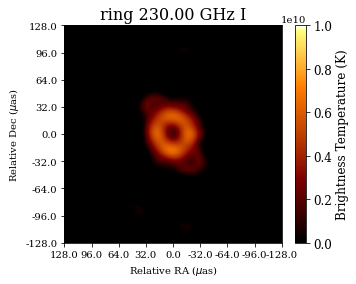

2022-07-27 16:41:04,191 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:04,193 INFO Display              :: Penalty--> 298.16427874274115
2022-07-27 16:41:04,314 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:04,316 INFO Display              :: Penalty--> 298.16427874274115
2022-07-27 16:41:04,429 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:04,430 INFO Display              :: Penalty--> 298.16427874274115
2022-07-27 16:41:04,551 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:04,553 INFO Display              :: Penalty--> 298.16427874274115
2022-07-27 16:41:04,679 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:04,681 INFO Display              :: Penalty--> 298.16427874274115
2022-07-27 16:41:04,820 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:04,822 INFO Display              :: Penalty--> 298.16427874274115
2022-07-27 16:41:04,945 INFO CountIterations      :: iteration = 7 / 2

2996.269863519572
Data Fidelity:  20.446540290589766


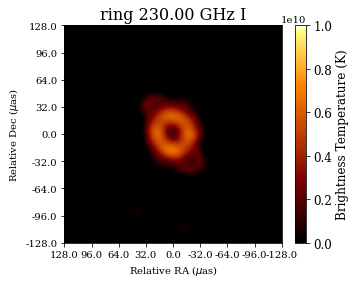

2022-07-27 16:41:07,646 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:07,648 INFO Display              :: Penalty--> 297.8455834538033
2022-07-27 16:41:07,780 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:07,782 INFO Display              :: Penalty--> 297.8455834538033
2022-07-27 16:41:07,898 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:07,900 INFO Display              :: Penalty--> 297.8455834538033
2022-07-27 16:41:08,015 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:08,017 INFO Display              :: Penalty--> 297.81493962044874
2022-07-27 16:41:08,138 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:08,139 INFO Display              :: Penalty--> 297.81493962044874
2022-07-27 16:41:08,272 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:08,274 INFO Display              :: Penalty--> 297.81493962044874
2022-07-27 16:41:08,399 INFO CountIterations      :: iteration = 7 / 25
2

2996.3745279916147
Data Fidelity:  19.813340251409116


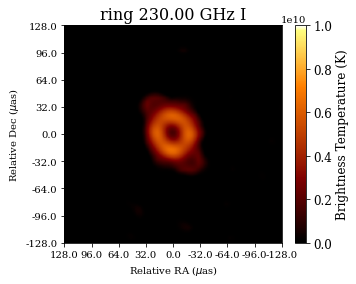

2022-07-27 16:41:11,222 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:11,224 INFO Display              :: Penalty--> 297.618819664929
2022-07-27 16:41:11,346 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:11,348 INFO Display              :: Penalty--> 297.618819664929
2022-07-27 16:41:11,473 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:11,475 INFO Display              :: Penalty--> 297.618819664929
2022-07-27 16:41:11,591 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:11,593 INFO Display              :: Penalty--> 297.618819664929
2022-07-27 16:41:11,726 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:11,728 INFO Display              :: Penalty--> 297.618819664929
2022-07-27 16:41:11,853 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:11,855 INFO Display              :: Penalty--> 297.618819664929
2022-07-27 16:41:11,983 INFO CountIterations      :: iteration = 7 / 25
2022-07-27

2996.4613644767796
Data Fidelity:  19.21383598076835


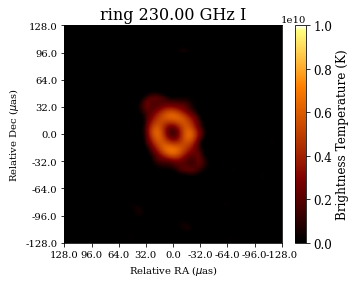

2022-07-27 16:41:14,799 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:14,800 INFO Display              :: Penalty--> 297.55753199821993
2022-07-27 16:41:14,917 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:14,919 INFO Display              :: Penalty--> 297.55753199821993
2022-07-27 16:41:15,038 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:15,040 INFO Display              :: Penalty--> 297.55753199821993
2022-07-27 16:41:15,163 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:15,165 INFO Display              :: Penalty--> 297.55753199821993
2022-07-27 16:41:15,288 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:15,290 INFO Display              :: Penalty--> 297.55753199821993
2022-07-27 16:41:15,421 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:15,423 INFO Display              :: Penalty--> 297.55753199821993
2022-07-27 16:41:15,546 INFO CountIterations      :: iteration = 7 / 2

2996.6051396485464
Data Fidelity:  18.640219438297414


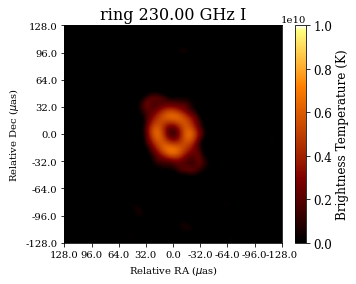

We use  6 scales with threshold 0.5
Current minimum 2776.7054595232803
Start optimization with thresholds [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
reverse mode: True
Updated at scale 2 to threshold 0.0 to minimum 2714.8085275440117
Updated at scale 3 to threshold 0.0 to minimum 2712.105401428255
Updated at scale 3 to threshold 4.5 to minimum 2710.663390515082
Updated at scale 6 to threshold 1.0 to minimum 2680.939076919124
Updated at scale 6 to threshold 1.5 to minimum 2662.0774225483674
Updated at scale 6 to threshold 2.0 to minimum 2646.887347442302
Updated at scale 6 to threshold 2.5 to minimum 2627.7714973672305
Updated at scale 6 to threshold 3.0 to minimum 2609.1792802956825
Updated at scale 6 to threshold 3.5 to minimum 2596.137360414936
Updated at scale 6 to threshold 4.0 to minimum 2584.762572616772
Updated at scale 6 to threshold 4.5 to minimum 2571.4753974958326
Updated at scale 6 to threshold 5.0 to minimum 2562.996029426863
Updated at scale 6 to threshold 5.5 to minimum 2550.81419909

2022-07-27 16:41:29,632 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:29,634 INFO Display              :: Penalty--> 776.3221407740305


Updated at scale 6 to threshold 9.5 to minimum 2468.000868095122
We use thresholds:  [0.5 0.5 0.  4.5 0.5 0.5 9.5]


2022-07-27 16:41:29,781 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:29,783 INFO Display              :: Penalty--> 731.8913162392344
2022-07-27 16:41:29,914 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:29,916 INFO Display              :: Penalty--> 721.3856348682933
2022-07-27 16:41:30,037 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:30,040 INFO Display              :: Penalty--> 712.9892459132736
2022-07-27 16:41:30,174 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:30,176 INFO Display              :: Penalty--> 706.4330145275999
2022-07-27 16:41:30,294 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:30,297 INFO Display              :: Penalty--> 699.5044623005163
2022-07-27 16:41:30,435 INFO CountIterations      :: iteration = 7 / 25
2022-07-27 16:41:30,437 INFO Display              :: Penalty--> 691.6213569762361
2022-07-27 16:41:30,559 INFO CountIterations      :: iteration = 8 / 25
2022

2761.792870605784
Data Fidelity:  207.75177395386174


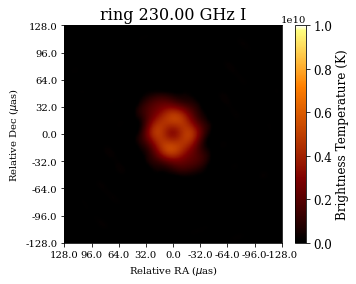

2022-07-27 16:41:33,114 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:33,116 INFO Display              :: Penalty--> 617.062586723847
2022-07-27 16:41:33,248 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:33,250 INFO Display              :: Penalty--> 617.0012990571379
2022-07-27 16:41:33,384 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:33,386 INFO Display              :: Penalty--> 616.3102823488409
2022-07-27 16:41:33,517 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:33,520 INFO Display              :: Penalty--> 615.5564463601165
2022-07-27 16:41:33,646 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:33,648 INFO Display              :: Penalty--> 614.5160911074763
2022-07-27 16:41:33,782 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:33,784 INFO Display              :: Penalty--> 613.3225166880637
2022-07-27 16:41:33,902 INFO CountIterations      :: iteration = 7 / 25
2022-

2952.7484712881374
Data Fidelity:  122.87074849487023


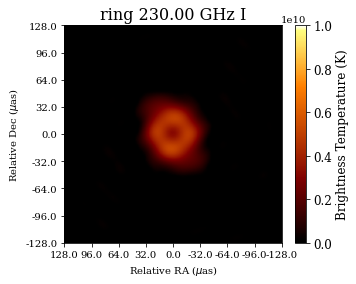

2022-07-27 16:41:36,595 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:36,597 INFO Display              :: Penalty--> 587.860630687186
2022-07-27 16:41:36,719 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:36,720 INFO Display              :: Penalty--> 587.3258975289972
2022-07-27 16:41:36,843 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:36,844 INFO Display              :: Penalty--> 586.365216243079
2022-07-27 16:41:36,967 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:36,969 INFO Display              :: Penalty--> 585.1272094212006
2022-07-27 16:41:37,102 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:37,104 INFO Display              :: Penalty--> 584.630781054705
2022-07-27 16:41:37,217 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:37,218 INFO Display              :: Penalty--> 584.3825665824826
2022-07-27 16:41:37,330 INFO CountIterations      :: iteration = 7 / 25
2022-07

2963.4005682271636
Data Fidelity:  88.48068021146096


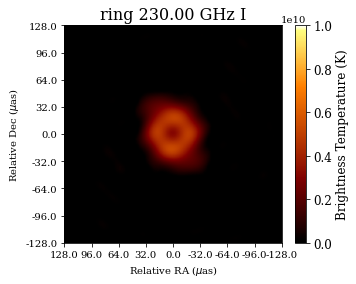

2022-07-27 16:41:40,034 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:40,036 INFO Display              :: Penalty--> 574.4861683422006
2022-07-27 16:41:40,157 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:40,160 INFO Display              :: Penalty--> 574.2594045533262
2022-07-27 16:41:40,267 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:40,269 INFO Display              :: Penalty--> 574.199649078285
2022-07-27 16:41:40,407 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:40,409 INFO Display              :: Penalty--> 573.6342720867417
2022-07-27 16:41:40,519 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:40,521 INFO Display              :: Penalty--> 573.1271183785718
2022-07-27 16:41:40,667 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:40,669 INFO Display              :: Penalty--> 572.920273081378
2022-07-27 16:41:40,801 INFO CountIterations      :: iteration = 7 / 25
2022-0

2970.2355390115536
Data Fidelity:  69.86089570777447


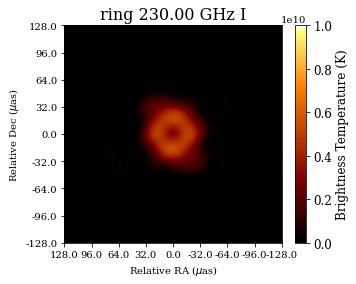

2022-07-27 16:41:43,505 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:43,507 INFO Display              :: Penalty--> 565.4891654549757
2022-07-27 16:41:43,655 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:43,656 INFO Display              :: Penalty--> 565.4278777882666
2022-07-27 16:41:43,789 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:43,790 INFO Display              :: Penalty--> 565.0785392439235
2022-07-27 16:41:43,941 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:43,944 INFO Display              :: Penalty--> 564.6556554995294
2022-07-27 16:41:44,091 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:44,093 INFO Display              :: Penalty--> 564.4901793773641
2022-07-27 16:41:44,225 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:44,226 INFO Display              :: Penalty--> 564.1132613830019
2022-07-27 16:41:44,350 INFO CountIterations      :: iteration = 7 / 25
2022

2975.0616547830778
Data Fidelity:  58.04543780979452


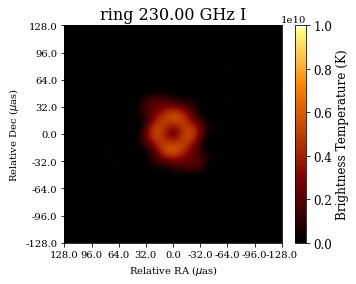

2022-07-27 16:41:47,536 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:47,538 INFO Display              :: Penalty--> 559.157163205886
2022-07-27 16:41:47,662 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:47,668 INFO Display              :: Penalty--> 559.1157940308575
2022-07-27 16:41:47,813 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:47,816 INFO Display              :: Penalty--> 559.0774892391643
2022-07-27 16:41:47,939 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:47,941 INFO Display              :: Penalty--> 559.0162015724552
2022-07-27 16:41:48,071 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:48,073 INFO Display              :: Penalty--> 559.0162015724552
2022-07-27 16:41:48,201 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:48,203 INFO Display              :: Penalty--> 559.0162015724552
2022-07-27 16:41:48,322 INFO CountIterations      :: iteration = 7 / 25
2022-

2978.561577520236
Data Fidelity:  50.14324374374621


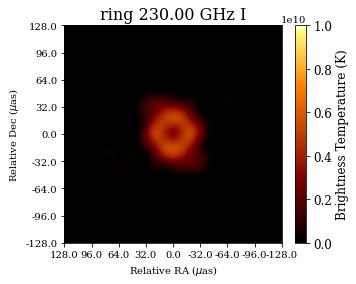

2022-07-27 16:41:51,095 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:51,097 INFO Display              :: Penalty--> 555.1903293812284
2022-07-27 16:41:51,225 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:51,227 INFO Display              :: Penalty--> 555.1903293812284
2022-07-27 16:41:51,357 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:51,358 INFO Display              :: Penalty--> 555.0983978811647
2022-07-27 16:41:51,483 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:51,484 INFO Display              :: Penalty--> 555.0983978811647
2022-07-27 16:41:51,620 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:51,622 INFO Display              :: Penalty--> 555.0064663811012
2022-07-27 16:41:51,754 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:51,756 INFO Display              :: Penalty--> 555.0064663811012
2022-07-27 16:41:51,883 INFO CountIterations      :: iteration = 7 / 25
2022

2981.42351901023
Data Fidelity:  43.868502080878926


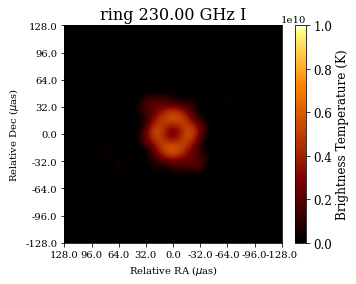

2022-07-27 16:41:54,601 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:54,602 INFO Display              :: Penalty--> 550.4456730763093
2022-07-27 16:41:54,731 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:54,732 INFO Display              :: Penalty--> 550.218909287435
2022-07-27 16:41:54,857 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:54,859 INFO Display              :: Penalty--> 550.2112483290964
2022-07-27 16:41:54,985 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:54,987 INFO Display              :: Penalty--> 550.1698791540678
2022-07-27 16:41:55,127 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:55,129 INFO Display              :: Penalty--> 549.6428069542176
2022-07-27 16:41:55,260 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:55,262 INFO Display              :: Penalty--> 549.3118547098871
2022-07-27 16:41:55,392 INFO CountIterations      :: iteration = 7 / 25
2022-

2983.3855142161083
Data Fidelity:  38.948386596996414


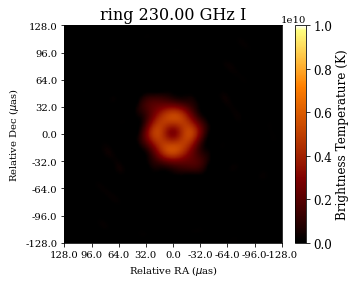

2022-07-27 16:41:58,258 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:41:58,260 INFO Display              :: Penalty--> 544.3756761803502
2022-07-27 16:41:58,393 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:41:58,394 INFO Display              :: Penalty--> 544.2837446802865
2022-07-27 16:41:58,515 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:41:58,517 INFO Display              :: Penalty--> 543.7873163137908
2022-07-27 16:41:58,648 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:41:58,649 INFO Display              :: Penalty--> 543.7459471387622
2022-07-27 16:41:58,764 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:41:58,765 INFO Display              :: Penalty--> 543.7153033054077
2022-07-27 16:41:58,883 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:41:58,884 INFO Display              :: Penalty--> 543.6846594720531
2022-07-27 16:41:59,007 INFO CountIterations      :: iteration = 7 / 25
2022

2985.1862424866054
Data Fidelity:  35.15658455985005


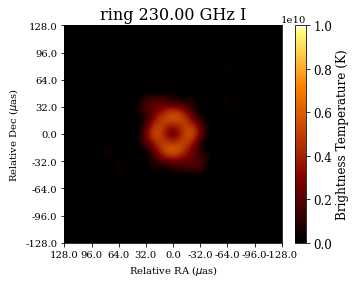

2022-07-27 16:42:01,835 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:01,837 INFO Display              :: Penalty--> 541.738781833533
2022-07-27 16:42:01,959 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:01,962 INFO Display              :: Penalty--> 541.4078295892026
2022-07-27 16:42:02,083 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:02,085 INFO Display              :: Penalty--> 541.2209027836893
2022-07-27 16:42:02,210 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:02,212 INFO Display              :: Penalty--> 541.055426661524
2022-07-27 16:42:02,337 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:02,339 INFO Display              :: Penalty--> 541.055426661524
2022-07-27 16:42:02,453 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:02,454 INFO Display              :: Penalty--> 541.055426661524
2022-07-27 16:42:02,584 INFO CountIterations      :: iteration = 7 / 25
2022-07-

2986.7972579722154
Data Fidelity:  32.01611140385544


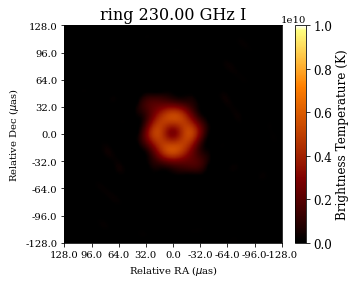

2022-07-27 16:42:05,473 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:05,475 INFO Display              :: Penalty--> 539.2106725171752
2022-07-27 16:42:05,602 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:05,604 INFO Display              :: Penalty--> 539.2106725171752
2022-07-27 16:42:05,722 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:05,724 INFO Display              :: Penalty--> 539.2106725171752
2022-07-27 16:42:05,863 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:05,865 INFO Display              :: Penalty--> 539.0451963950101
2022-07-27 16:42:05,988 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:05,990 INFO Display              :: Penalty--> 539.0145525616555
2022-07-27 16:42:06,117 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:06,119 INFO Display              :: Penalty--> 539.0145525616555
2022-07-27 16:42:06,252 INFO CountIterations      :: iteration = 7 / 25
2022

2987.8551346079394
Data Fidelity:  29.37001685550411


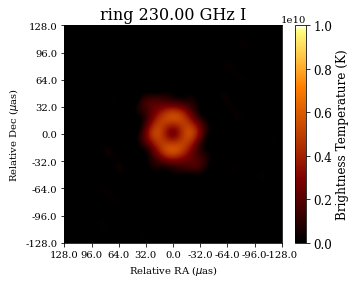

2022-07-27 16:42:09,866 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:09,868 INFO Display              :: Penalty--> 537.1177039006039
2022-07-27 16:42:10,063 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:10,066 INFO Display              :: Penalty--> 537.0870600672494
2022-07-27 16:42:10,276 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:10,280 INFO Display              :: Penalty--> 537.0564162338948
2022-07-27 16:42:10,480 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:10,482 INFO Display              :: Penalty--> 537.0257724005403
2022-07-27 16:42:10,676 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:10,680 INFO Display              :: Penalty--> 536.8602962783751
2022-07-27 16:42:10,877 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:10,880 INFO Display              :: Penalty--> 536.8112661450078
2022-07-27 16:42:11,078 INFO CountIterations      :: iteration = 7 / 25
2022

2988.740717866828
Data Fidelity:  27.10332219915709


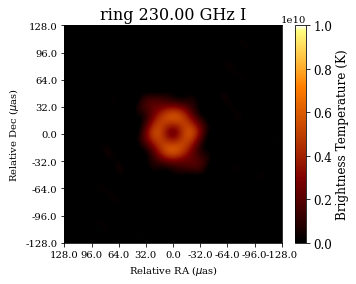

2022-07-27 16:42:14,999 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:15,001 INFO Display              :: Penalty--> 535.1488428091185
2022-07-27 16:42:15,167 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:15,169 INFO Display              :: Penalty--> 535.1488428091185
2022-07-27 16:42:15,327 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:15,328 INFO Display              :: Penalty--> 534.9220790202442
2022-07-27 16:42:15,481 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:15,483 INFO Display              :: Penalty--> 534.9220790202442
2022-07-27 16:42:15,635 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:15,637 INFO Display              :: Penalty--> 534.9220790202442
2022-07-27 16:42:15,787 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:15,790 INFO Display              :: Penalty--> 534.7489419397403
2022-07-27 16:42:15,939 INFO CountIterations      :: iteration = 7 / 25
2022

2989.9000838367974
Data Fidelity:  25.05209312026569


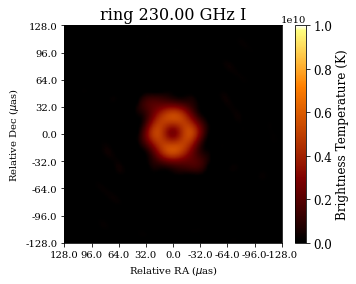

2022-07-27 16:42:19,500 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:19,503 INFO Display              :: Penalty--> 532.5196099985892
2022-07-27 16:42:19,681 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:19,683 INFO Display              :: Penalty--> 532.5196099985892
2022-07-27 16:42:19,842 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:19,845 INFO Display              :: Penalty--> 532.5196099985892
2022-07-27 16:42:20,021 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:20,023 INFO Display              :: Penalty--> 532.4889661652347
2022-07-27 16:42:20,203 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:20,205 INFO Display              :: Penalty--> 532.4889661652347
2022-07-27 16:42:20,372 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:20,374 INFO Display              :: Penalty--> 532.3127647013953
2022-07-27 16:42:20,521 INFO CountIterations      :: iteration = 7 / 25
2022

2990.3458321149124
Data Fidelity:  23.306992340085408


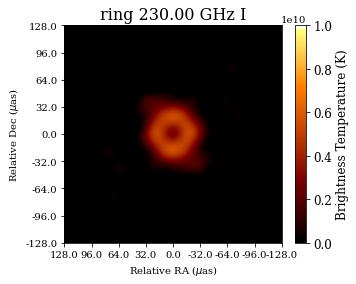

2022-07-27 16:42:24,137 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:24,140 INFO Display              :: Penalty--> 530.7867058459844
2022-07-27 16:42:24,326 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:24,328 INFO Display              :: Penalty--> 530.7867058459844
2022-07-27 16:42:24,489 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:24,492 INFO Display              :: Penalty--> 530.6105043821451
2022-07-27 16:42:24,657 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:24,660 INFO Display              :: Penalty--> 530.5798605487905
2022-07-27 16:42:24,822 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:24,825 INFO Display              :: Penalty--> 530.4143844266254
2022-07-27 16:42:24,974 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:24,976 INFO Display              :: Penalty--> 530.0757712239563
2022-07-27 16:42:25,133 INFO CountIterations      :: iteration = 7 / 25
2022

2991.0651357083634
Data Fidelity:  21.76601626482329


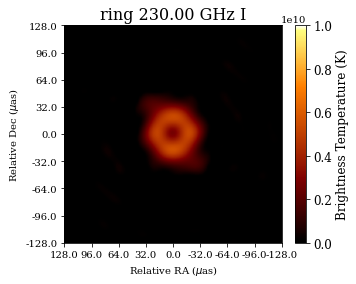

2022-07-27 16:42:28,067 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:28,069 INFO Display              :: Penalty--> 528.381172440994
2022-07-27 16:42:28,187 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:28,188 INFO Display              :: Penalty--> 528.3505286076395
2022-07-27 16:42:28,301 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:28,303 INFO Display              :: Penalty--> 528.1544086521197
2022-07-27 16:42:28,429 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:28,430 INFO Display              :: Penalty--> 527.9889325299545
2022-07-27 16:42:28,545 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:28,547 INFO Display              :: Penalty--> 527.9889325299545
2022-07-27 16:42:28,659 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:28,661 INFO Display              :: Penalty--> 527.9506277382613
2022-07-27 16:42:28,792 INFO CountIterations      :: iteration = 7 / 25
2022-

2991.722435853102
Data Fidelity:  20.40302745797844


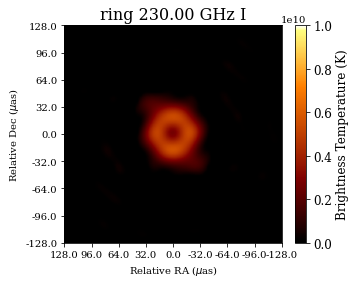

2022-07-27 16:42:31,413 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:31,415 INFO Display              :: Penalty--> 526.628350374658
2022-07-27 16:42:31,551 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:31,553 INFO Display              :: Penalty--> 526.5977065413034
2022-07-27 16:42:31,671 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:31,673 INFO Display              :: Penalty--> 526.5670627079489
2022-07-27 16:42:31,812 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:31,815 INFO Display              :: Penalty--> 526.5594017496103
2022-07-27 16:42:31,938 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:31,940 INFO Display              :: Penalty--> 526.5517407912718
2022-07-27 16:42:32,063 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:32,064 INFO Display              :: Penalty--> 526.2207885469413
2022-07-27 16:42:32,194 INFO CountIterations      :: iteration = 7 / 25
2022-

2992.213294229746
Data Fidelity:  19.20219986195592


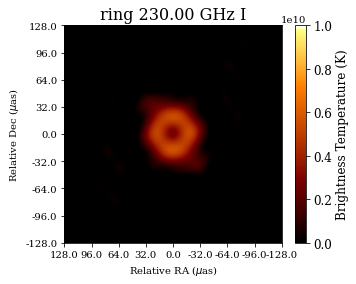

2022-07-27 16:42:34,916 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:34,919 INFO Display              :: Penalty--> 525.5313040303121
2022-07-27 16:42:35,049 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:35,050 INFO Display              :: Penalty--> 525.5313040303121
2022-07-27 16:42:35,172 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:35,174 INFO Display              :: Penalty--> 525.3658279081469
2022-07-27 16:42:35,296 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:35,299 INFO Display              :: Penalty--> 525.3658279081469
2022-07-27 16:42:35,425 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:35,427 INFO Display              :: Penalty--> 525.3658279081469
2022-07-27 16:42:35,545 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:35,547 INFO Display              :: Penalty--> 525.3351840747923
2022-07-27 16:42:35,664 INFO CountIterations      :: iteration = 7 / 25
2022

2992.7590494961496
Data Fidelity:  18.1160945459933


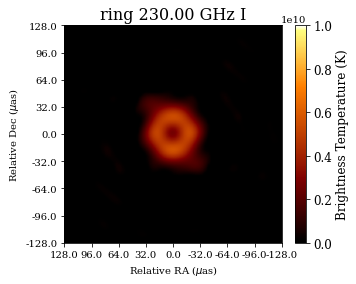

2022-07-27 16:42:38,361 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:38,362 INFO Display              :: Penalty--> 524.3024897804909
2022-07-27 16:42:38,486 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:38,488 INFO Display              :: Penalty--> 524.3024897804909
2022-07-27 16:42:38,607 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:38,609 INFO Display              :: Penalty--> 524.1262883166515
2022-07-27 16:42:38,772 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:38,774 INFO Display              :: Penalty--> 524.0879835249583
2022-07-27 16:42:38,906 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:38,908 INFO Display              :: Penalty--> 523.9225074027931
2022-07-27 16:42:39,036 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:39,038 INFO Display              :: Penalty--> 523.7493703222892
2022-07-27 16:42:39,188 INFO CountIterations      :: iteration = 7 / 25
2022

2993.096988779017
Data Fidelity:  17.11638071707162


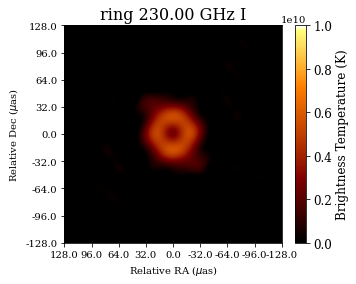

2022-07-27 16:42:42,054 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:42,055 INFO Display              :: Penalty--> 522.6431314058862
2022-07-27 16:42:42,188 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:42,189 INFO Display              :: Penalty--> 522.6431314058862
2022-07-27 16:42:42,320 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:42,322 INFO Display              :: Penalty--> 522.6431314058862
2022-07-27 16:42:42,441 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:42,444 INFO Display              :: Penalty--> 522.6431314058862
2022-07-27 16:42:42,581 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:42,583 INFO Display              :: Penalty--> 522.6431314058862
2022-07-27 16:42:42,712 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:42,714 INFO Display              :: Penalty--> 522.6431314058862
2022-07-27 16:42:42,823 INFO CountIterations      :: iteration = 7 / 25
2022

2993.504887210348
Data Fidelity:  16.200805854885036


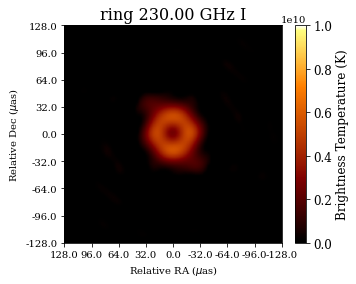

2022-07-27 16:42:45,545 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:45,549 INFO Display              :: Penalty--> 520.9393394729176
2022-07-27 16:42:45,685 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:45,687 INFO Display              :: Penalty--> 520.9393394729176
2022-07-27 16:42:45,805 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:45,807 INFO Display              :: Penalty--> 520.7432195173977
2022-07-27 16:42:45,934 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:45,935 INFO Display              :: Penalty--> 520.7432195173977
2022-07-27 16:42:46,056 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:46,058 INFO Display              :: Penalty--> 520.7432195173977
2022-07-27 16:42:46,185 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:46,186 INFO Display              :: Penalty--> 520.7432195173977
2022-07-27 16:42:46,328 INFO CountIterations      :: iteration = 7 / 25
2022

2993.8146353701595
Data Fidelity:  15.397701463492389


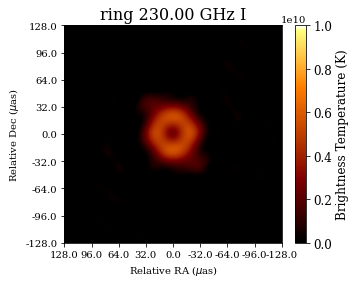

2022-07-27 16:42:49,184 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:49,186 INFO Display              :: Penalty--> 520.0537350007686
2022-07-27 16:42:49,313 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:49,315 INFO Display              :: Penalty--> 520.0537350007686
2022-07-27 16:42:49,441 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:49,443 INFO Display              :: Penalty--> 520.0537350007686
2022-07-27 16:42:49,581 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:49,582 INFO Display              :: Penalty--> 519.8576150452487
2022-07-27 16:42:49,716 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:49,718 INFO Display              :: Penalty--> 519.6814135814095
2022-07-27 16:42:49,838 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:49,840 INFO Display              :: Penalty--> 519.650769748055
2022-07-27 16:42:49,963 INFO CountIterations      :: iteration = 7 / 25
2022-

2994.1487160601073
Data Fidelity:  14.623328796116827


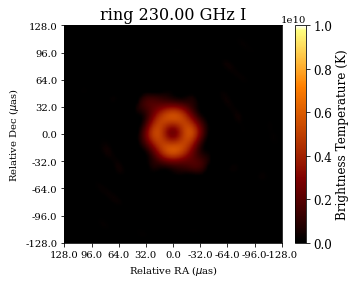

2022-07-27 16:42:52,824 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:52,826 INFO Display              :: Penalty--> 518.4112301565598
2022-07-27 16:42:52,954 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:52,956 INFO Display              :: Penalty--> 518.4112301565598
2022-07-27 16:42:53,092 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:53,094 INFO Display              :: Penalty--> 518.4112301565598
2022-07-27 16:42:53,219 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:53,221 INFO Display              :: Penalty--> 518.4112301565598
2022-07-27 16:42:53,345 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:53,347 INFO Display              :: Penalty--> 518.4112301565598
2022-07-27 16:42:53,524 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:53,526 INFO Display              :: Penalty--> 518.3805863232052
2022-07-27 16:42:53,668 INFO CountIterations      :: iteration = 7 / 25
2022

2994.398328819303
Data Fidelity:  13.928817705706198


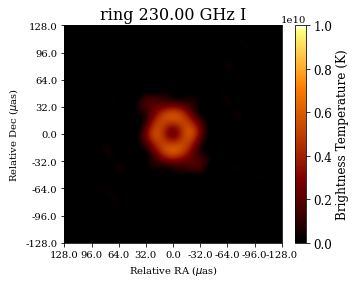

2022-07-27 16:42:56,604 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:42:56,606 INFO Display              :: Penalty--> 516.7595321623445
2022-07-27 16:42:56,734 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:42:56,736 INFO Display              :: Penalty--> 516.7288883289899
2022-07-27 16:42:56,865 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:42:56,867 INFO Display              :: Penalty--> 516.3979360846595
2022-07-27 16:42:57,001 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:42:57,003 INFO Display              :: Penalty--> 516.3979360846595
2022-07-27 16:42:57,147 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:42:57,148 INFO Display              :: Penalty--> 516.3979360846595
2022-07-27 16:42:57,290 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:42:57,292 INFO Display              :: Penalty--> 516.3979360846595
2022-07-27 16:42:57,434 INFO CountIterations      :: iteration = 7 / 25
2022

2994.8129179529033
Data Fidelity:  13.308801285744343


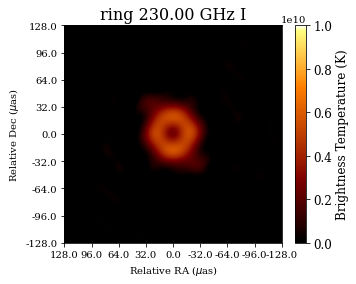

2022-07-27 16:43:00,466 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:00,469 INFO Display              :: Penalty--> 516.3075367762636
2022-07-27 16:43:00,637 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:00,639 INFO Display              :: Penalty--> 516.3075367762636
2022-07-27 16:43:00,823 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:00,825 INFO Display              :: Penalty--> 516.1313353124243
2022-07-27 16:43:00,983 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:00,985 INFO Display              :: Penalty--> 516.1313353124243
2022-07-27 16:43:01,176 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:01,178 INFO Display              :: Penalty--> 516.1313353124243
2022-07-27 16:43:01,371 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:01,373 INFO Display              :: Penalty--> 516.1006914790697
2022-07-27 16:43:01,538 INFO CountIterations      :: iteration = 7 / 25
2022

2995.097911391974
Data Fidelity:  12.734529350376377


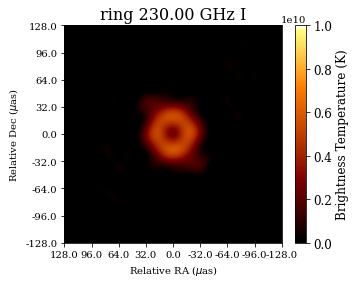

2022-07-27 16:43:04,750 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:04,752 INFO Display              :: Penalty--> 515.7099831817487
2022-07-27 16:43:04,872 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:04,874 INFO Display              :: Penalty--> 515.5445070595836
2022-07-27 16:43:05,024 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:05,026 INFO Display              :: Penalty--> 515.5445070595836
2022-07-27 16:43:05,158 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:05,160 INFO Display              :: Penalty--> 515.5445070595836
2022-07-27 16:43:05,298 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:05,301 INFO Display              :: Penalty--> 515.3683055957441
2022-07-27 16:43:05,435 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:05,437 INFO Display              :: Penalty--> 515.3683055957441
2022-07-27 16:43:05,564 INFO CountIterations      :: iteration = 7 / 25
2022

2995.194289696379
Data Fidelity:  12.195159779373293


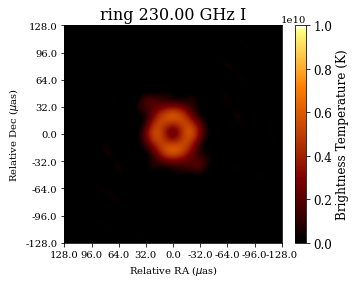

2022-07-27 16:43:08,408 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:08,411 INFO Display              :: Penalty--> 514.5960827290577
2022-07-27 16:43:08,582 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:08,583 INFO Display              :: Penalty--> 514.5960827290577
2022-07-27 16:43:08,706 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:08,707 INFO Display              :: Penalty--> 514.5960827290577
2022-07-27 16:43:08,841 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:08,843 INFO Display              :: Penalty--> 514.5960827290577
2022-07-27 16:43:08,963 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:08,965 INFO Display              :: Penalty--> 514.5960827290577
2022-07-27 16:43:09,102 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:09,104 INFO Display              :: Penalty--> 514.5960827290577
2022-07-27 16:43:09,223 INFO CountIterations      :: iteration = 7 / 25
2022

2995.4137040778114
Data Fidelity:  11.702901773323179


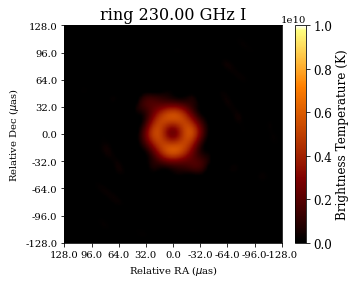

2022-07-27 16:43:11,907 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:11,909 INFO Display              :: Penalty--> 513.7380582848771
2022-07-27 16:43:12,032 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:12,033 INFO Display              :: Penalty--> 513.7380582848771
2022-07-27 16:43:12,142 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:12,144 INFO Display              :: Penalty--> 513.7380582848771
2022-07-27 16:43:12,257 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:12,259 INFO Display              :: Penalty--> 513.7380582848771
2022-07-27 16:43:12,364 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:12,366 INFO Display              :: Penalty--> 513.7380582848771
2022-07-27 16:43:12,490 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:12,492 INFO Display              :: Penalty--> 513.5725821627119
2022-07-27 16:43:12,615 INFO CountIterations      :: iteration = 7 / 25
2022

2995.6077605530336
Data Fidelity:  11.233052705980844


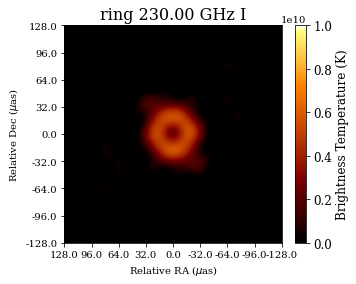

2022-07-27 16:43:15,211 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:15,212 INFO Display              :: Penalty--> 512.7666516572848
2022-07-27 16:43:15,328 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:15,329 INFO Display              :: Penalty--> 512.7666516572848
2022-07-27 16:43:15,450 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:15,452 INFO Display              :: Penalty--> 512.6011755351195
2022-07-27 16:43:15,562 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:15,564 INFO Display              :: Penalty--> 512.6011755351195
2022-07-27 16:43:15,683 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:15,685 INFO Display              :: Penalty--> 512.6011755351195
2022-07-27 16:43:15,807 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:15,809 INFO Display              :: Penalty--> 512.4356994129544
2022-07-27 16:43:15,924 INFO CountIterations      :: iteration = 7 / 25
2022

2995.741522066261
Data Fidelity:  10.813848714649342


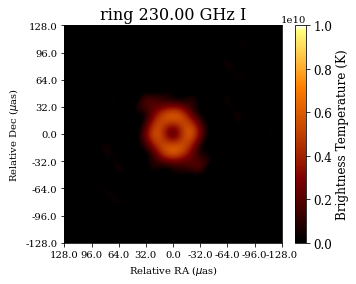

2022-07-27 16:43:18,550 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:18,552 INFO Display              :: Penalty--> 511.67420246589126
2022-07-27 16:43:18,669 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:18,671 INFO Display              :: Penalty--> 511.67420246589126
2022-07-27 16:43:18,787 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:18,788 INFO Display              :: Penalty--> 511.67420246589126
2022-07-27 16:43:18,903 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:18,904 INFO Display              :: Penalty--> 511.67420246589126
2022-07-27 16:43:19,025 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:19,028 INFO Display              :: Penalty--> 511.6052538408435
2022-07-27 16:43:19,164 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:19,167 INFO Display              :: Penalty--> 511.6052538408435
2022-07-27 16:43:19,294 INFO CountIterations      :: iteration = 7 / 25


2995.8969502714126
Data Fidelity:  10.414763935964439


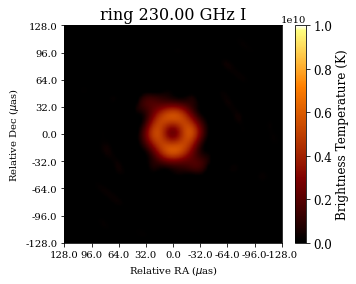

2022-07-27 16:43:21,937 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:21,939 INFO Display              :: Penalty--> 510.9985076742715
2022-07-27 16:43:22,070 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:22,072 INFO Display              :: Penalty--> 510.9985076742715
2022-07-27 16:43:22,191 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:22,193 INFO Display              :: Penalty--> 510.9985076742715
2022-07-27 16:43:22,320 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:22,322 INFO Display              :: Penalty--> 510.9985076742715
2022-07-27 16:43:22,427 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:22,429 INFO Display              :: Penalty--> 510.9985076742715
2022-07-27 16:43:22,549 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:22,550 INFO Display              :: Penalty--> 510.9985076742715
2022-07-27 16:43:22,678 INFO CountIterations      :: iteration = 7 / 25
2022

2996.058086984868
Data Fidelity:  10.057081490336476


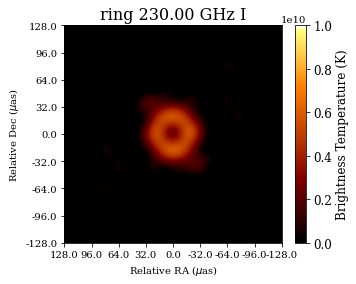

2022-07-27 16:43:25,377 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:25,380 INFO Display              :: Penalty--> 509.9448906938194
2022-07-27 16:43:25,507 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:25,509 INFO Display              :: Penalty--> 509.93416535214527
2022-07-27 16:43:25,631 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:25,633 INFO Display              :: Penalty--> 509.93416535214527
2022-07-27 16:43:25,762 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:25,764 INFO Display              :: Penalty--> 509.93416535214527
2022-07-27 16:43:25,881 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:25,882 INFO Display              :: Penalty--> 509.93416535214527
2022-07-27 16:43:26,015 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:26,017 INFO Display              :: Penalty--> 509.76868922998
2022-07-27 16:43:26,144 INFO CountIterations      :: iteration = 7 / 25
20

2996.284954069581
Data Fidelity:  9.722326906516813


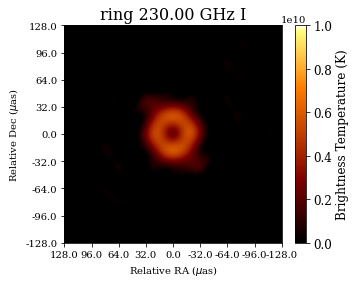

2022-07-27 16:43:28,824 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:28,825 INFO Display              :: Penalty--> 509.32741918557326
2022-07-27 16:43:28,954 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:28,956 INFO Display              :: Penalty--> 509.28911439388014
2022-07-27 16:43:29,079 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:29,081 INFO Display              :: Penalty--> 509.28911439388014
2022-07-27 16:43:29,220 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:29,222 INFO Display              :: Penalty--> 509.28911439388014
2022-07-27 16:43:29,334 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:29,336 INFO Display              :: Penalty--> 509.28911439388014
2022-07-27 16:43:29,458 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:29,460 INFO Display              :: Penalty--> 509.123638271715
2022-07-27 16:43:29,590 INFO CountIterations      :: iteration = 7 / 25


2996.3652786928988
Data Fidelity:  9.405913477980633


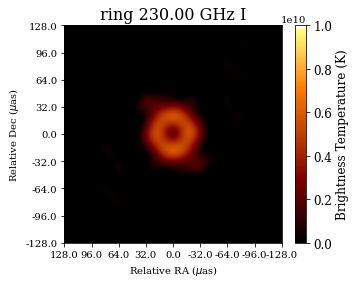

2022-07-27 16:43:32,319 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:32,321 INFO Display              :: Penalty--> 507.8840986802196
2022-07-27 16:43:32,436 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:32,438 INFO Display              :: Penalty--> 507.8840986802196
2022-07-27 16:43:32,567 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:32,569 INFO Display              :: Penalty--> 507.8840986802196
2022-07-27 16:43:32,698 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:32,700 INFO Display              :: Penalty--> 507.8534548468651
2022-07-27 16:43:32,826 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:32,828 INFO Display              :: Penalty--> 507.82281101351055
2022-07-27 16:43:32,951 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:32,953 INFO Display              :: Penalty--> 507.82281101351055
2022-07-27 16:43:33,120 INFO CountIterations      :: iteration = 7 / 25
20

2996.5200735247513
Data Fidelity:  9.113458882136486


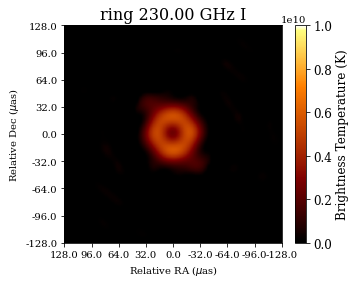

2022-07-27 16:43:35,979 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:35,981 INFO Display              :: Penalty--> 507.48113342750605
2022-07-27 16:43:36,096 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:36,098 INFO Display              :: Penalty--> 507.48113342750605
2022-07-27 16:43:36,220 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:36,222 INFO Display              :: Penalty--> 507.4504895941515
2022-07-27 16:43:36,344 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:36,346 INFO Display              :: Penalty--> 507.28501347198625
2022-07-27 16:43:36,483 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:36,485 INFO Display              :: Penalty--> 507.27428813031213
2022-07-27 16:43:36,606 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:36,607 INFO Display              :: Penalty--> 507.10881200814697
2022-07-27 16:43:36,730 INFO CountIterations      :: iteration = 7 / 25

2996.6772595104853
Data Fidelity:  8.836559427202891


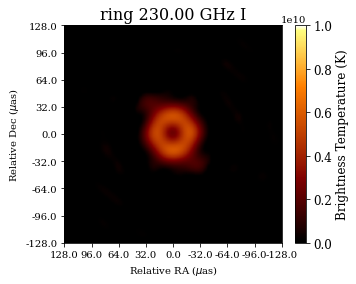

2022-07-27 16:43:39,508 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:39,510 INFO Display              :: Penalty--> 506.66447758040476
2022-07-27 16:43:39,638 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:39,640 INFO Display              :: Penalty--> 506.66447758040476
2022-07-27 16:43:39,790 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:39,792 INFO Display              :: Penalty--> 506.66447758040476
2022-07-27 16:43:39,919 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:39,921 INFO Display              :: Penalty--> 506.63383374705023
2022-07-27 16:43:40,054 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:40,055 INFO Display              :: Penalty--> 506.63383374705023
2022-07-27 16:43:40,184 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:40,186 INFO Display              :: Penalty--> 506.6031899136957
2022-07-27 16:43:40,314 INFO CountIterations      :: iteration = 7 / 25

2996.753665465957
Data Fidelity:  8.574960020099029


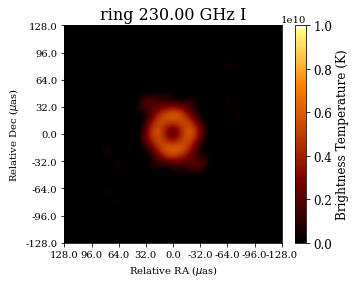

2022-07-27 16:43:43,213 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:43,214 INFO Display              :: Penalty--> 506.0546664525481
2022-07-27 16:43:43,338 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:43,341 INFO Display              :: Penalty--> 506.0546664525481
2022-07-27 16:43:43,462 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:43,463 INFO Display              :: Penalty--> 506.0546664525481
2022-07-27 16:43:43,590 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:43,592 INFO Display              :: Penalty--> 506.0546664525481
2022-07-27 16:43:43,705 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:43,707 INFO Display              :: Penalty--> 506.0546664525481
2022-07-27 16:43:43,826 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:43,828 INFO Display              :: Penalty--> 506.0546664525481
2022-07-27 16:43:43,938 INFO CountIterations      :: iteration = 7 / 25
2022

2996.91171584389
Data Fidelity:  8.348268001010128


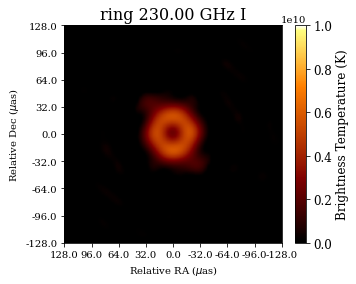

2022-07-27 16:43:46,628 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:46,630 INFO Display              :: Penalty--> 505.8478211553542
2022-07-27 16:43:46,753 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:46,756 INFO Display              :: Penalty--> 505.8478211553542
2022-07-27 16:43:46,874 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:46,877 INFO Display              :: Penalty--> 505.8478211553542
2022-07-27 16:43:46,993 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:46,994 INFO Display              :: Penalty--> 505.8478211553542
2022-07-27 16:43:47,120 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:47,122 INFO Display              :: Penalty--> 505.8478211553542
2022-07-27 16:43:47,236 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:47,237 INFO Display              :: Penalty--> 505.8478211553542
2022-07-27 16:43:47,355 INFO CountIterations      :: iteration = 7 / 25
2022

2997.011838069161
Data Fidelity:  8.119729366711459


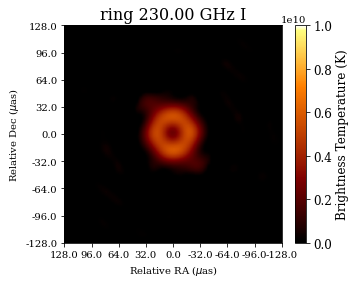

2022-07-27 16:43:50,035 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:50,038 INFO Display              :: Penalty--> 505.2594612887949
2022-07-27 16:43:50,149 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:50,151 INFO Display              :: Penalty--> 505.2594612887949
2022-07-27 16:43:50,269 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:50,270 INFO Display              :: Penalty--> 505.2594612887949
2022-07-27 16:43:50,393 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:50,394 INFO Display              :: Penalty--> 505.2288174554404
2022-07-27 16:43:50,512 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:50,514 INFO Display              :: Penalty--> 505.2288174554404
2022-07-27 16:43:50,642 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:50,644 INFO Display              :: Penalty--> 505.06334133327516
2022-07-27 16:43:50,778 INFO CountIterations      :: iteration = 7 / 25
202

2997.1496654560096
Data Fidelity:  7.907175069162436


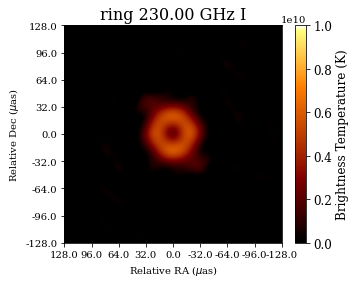

2022-07-27 16:43:53,441 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:53,442 INFO Display              :: Penalty--> 504.8151268610527
2022-07-27 16:43:53,558 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:53,560 INFO Display              :: Penalty--> 504.8151268610527
2022-07-27 16:43:53,687 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:53,689 INFO Display              :: Penalty--> 504.8151268610527
2022-07-27 16:43:53,862 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:53,863 INFO Display              :: Penalty--> 504.8151268610527
2022-07-27 16:43:53,994 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:53,995 INFO Display              :: Penalty--> 504.8151268610527
2022-07-27 16:43:54,123 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:54,125 INFO Display              :: Penalty--> 504.7844830276982
2022-07-27 16:43:54,237 INFO CountIterations      :: iteration = 7 / 25
2022

2997.2096313059765
Data Fidelity:  7.713970765921613


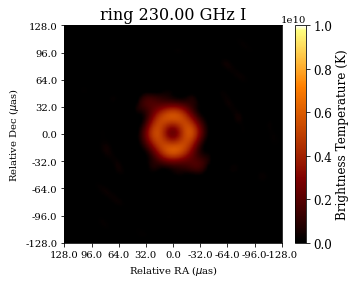

2022-07-27 16:43:57,026 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:43:57,028 INFO Display              :: Penalty--> 504.38917873332326
2022-07-27 16:43:57,141 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:43:57,143 INFO Display              :: Penalty--> 504.38917873332326
2022-07-27 16:43:57,267 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:43:57,269 INFO Display              :: Penalty--> 504.38917873332326
2022-07-27 16:43:57,393 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:43:57,394 INFO Display              :: Penalty--> 504.38917873332326
2022-07-27 16:43:57,506 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:43:57,507 INFO Display              :: Penalty--> 504.22370261115805
2022-07-27 16:43:57,626 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:43:57,628 INFO Display              :: Penalty--> 504.22370261115805
2022-07-27 16:43:57,775 INFO CountIterations      :: iteration = 7 / 2

2997.2915287534884
Data Fidelity:  7.518398019312859


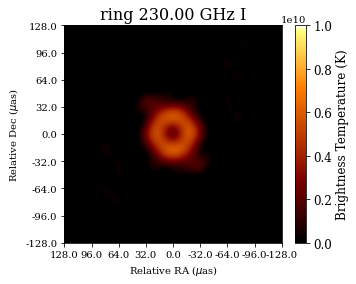

2022-07-27 16:44:00,436 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:00,438 INFO Display              :: Penalty--> 503.6353427445988
2022-07-27 16:44:00,562 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:00,565 INFO Display              :: Penalty--> 503.6353427445988
2022-07-27 16:44:00,696 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:00,698 INFO Display              :: Penalty--> 503.6353427445988
2022-07-27 16:44:00,821 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:00,823 INFO Display              :: Penalty--> 503.6353427445988
2022-07-27 16:44:00,940 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:00,942 INFO Display              :: Penalty--> 503.6353427445988
2022-07-27 16:44:01,071 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:01,073 INFO Display              :: Penalty--> 503.6246174029247
2022-07-27 16:44:01,192 INFO CountIterations      :: iteration = 7 / 25
2022

2997.3700106057745
Data Fidelity:  7.3453292766449065


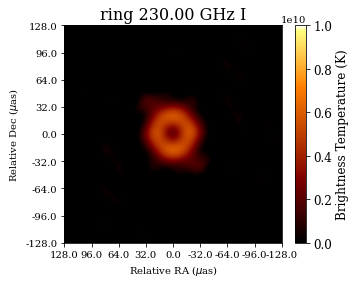

2022-07-27 16:44:03,814 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:03,816 INFO Display              :: Penalty--> 503.53268590286115
2022-07-27 16:44:03,942 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:03,944 INFO Display              :: Penalty--> 503.53268590286115
2022-07-27 16:44:04,054 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:04,056 INFO Display              :: Penalty--> 503.53268590286115
2022-07-27 16:44:04,190 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:04,192 INFO Display              :: Penalty--> 503.53268590286115
2022-07-27 16:44:04,300 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:04,301 INFO Display              :: Penalty--> 503.50204206950656
2022-07-27 16:44:04,419 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:04,421 INFO Display              :: Penalty--> 503.50204206950656
2022-07-27 16:44:04,548 INFO CountIterations      :: iteration = 7 / 2

2997.478093579738
Data Fidelity:  7.18468630714048


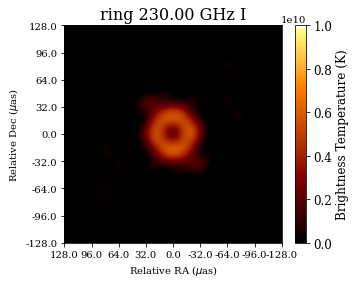

2022-07-27 16:44:07,204 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:07,206 INFO Display              :: Penalty--> 503.3258406056673
2022-07-27 16:44:07,321 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:07,322 INFO Display              :: Penalty--> 503.3258406056673
2022-07-27 16:44:07,443 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:07,445 INFO Display              :: Penalty--> 503.3258406056673
2022-07-27 16:44:07,563 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:07,565 INFO Display              :: Penalty--> 503.3258406056673
2022-07-27 16:44:07,690 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:07,692 INFO Display              :: Penalty--> 503.3258406056673
2022-07-27 16:44:07,821 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:07,823 INFO Display              :: Penalty--> 503.3258406056673
2022-07-27 16:44:07,939 INFO CountIterations      :: iteration = 7 / 25
2022

2997.523957728647
Data Fidelity:  7.028408041256058


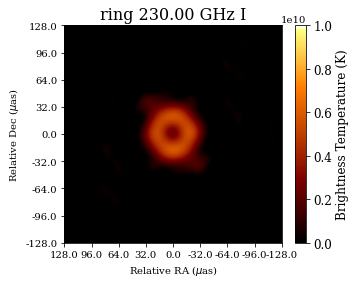

2022-07-27 16:44:10,655 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:10,659 INFO Display              :: Penalty--> 503.03012819174523
2022-07-27 16:44:10,786 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:10,789 INFO Display              :: Penalty--> 503.03012819174523
2022-07-27 16:44:10,917 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:10,919 INFO Display              :: Penalty--> 503.03012819174523
2022-07-27 16:44:11,044 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:11,045 INFO Display              :: Penalty--> 503.03012819174523
2022-07-27 16:44:11,175 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:11,176 INFO Display              :: Penalty--> 503.03012819174523
2022-07-27 16:44:11,313 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:11,314 INFO Display              :: Penalty--> 502.8340082362255
2022-07-27 16:44:11,439 INFO CountIterations      :: iteration = 7 / 25

2997.570070649236
Data Fidelity:  6.872391677743309


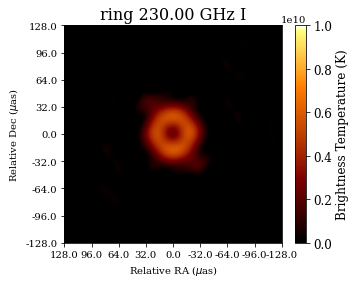

2022-07-27 16:44:14,148 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:14,150 INFO Display              :: Penalty--> 502.54595678064214
2022-07-27 16:44:14,290 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:14,292 INFO Display              :: Penalty--> 502.54595678064214
2022-07-27 16:44:14,412 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:14,415 INFO Display              :: Penalty--> 502.54595678064214
2022-07-27 16:44:14,536 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:14,538 INFO Display              :: Penalty--> 502.54595678064214
2022-07-27 16:44:14,674 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:14,676 INFO Display              :: Penalty--> 502.5153129472876
2022-07-27 16:44:14,807 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:14,809 INFO Display              :: Penalty--> 502.5153129472876
2022-07-27 16:44:14,934 INFO CountIterations      :: iteration = 7 / 25


2997.674710446285
Data Fidelity:  6.730281014474501


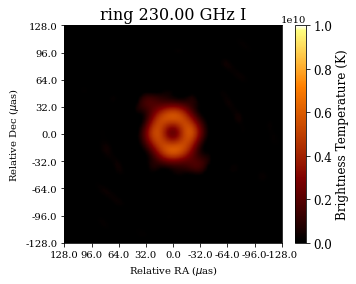

2022-07-27 16:44:17,678 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:17,679 INFO Display              :: Penalty--> 502.1858923166757
2022-07-27 16:44:17,805 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:17,807 INFO Display              :: Penalty--> 502.1858923166757
2022-07-27 16:44:17,935 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:17,937 INFO Display              :: Penalty--> 502.1858923166757
2022-07-27 16:44:18,066 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:18,067 INFO Display              :: Penalty--> 502.02041619451046
2022-07-27 16:44:18,194 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:18,196 INFO Display              :: Penalty--> 501.85494007234524
2022-07-27 16:44:18,337 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:18,338 INFO Display              :: Penalty--> 501.85494007234524
2022-07-27 16:44:18,464 INFO CountIterations      :: iteration = 7 / 25
2

2997.7216320503426
Data Fidelity:  6.5893324970639755


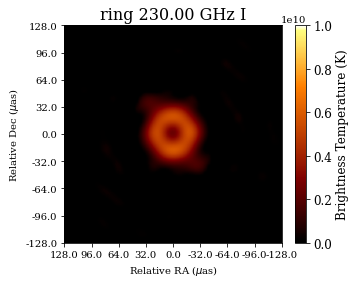

2022-07-27 16:44:21,237 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:21,239 INFO Display              :: Penalty--> 501.6603517305439
2022-07-27 16:44:21,370 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:21,372 INFO Display              :: Penalty--> 501.6603517305439
2022-07-27 16:44:21,511 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:21,513 INFO Display              :: Penalty--> 501.6603517305439
2022-07-27 16:44:21,631 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:21,633 INFO Display              :: Penalty--> 501.6603517305439
2022-07-27 16:44:21,758 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:21,760 INFO Display              :: Penalty--> 501.6603517305439
2022-07-27 16:44:21,892 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:21,894 INFO Display              :: Penalty--> 501.6603517305439
2022-07-27 16:44:22,038 INFO CountIterations      :: iteration = 7 / 25
2022

2997.8742471957084
Data Fidelity:  6.458027099142098


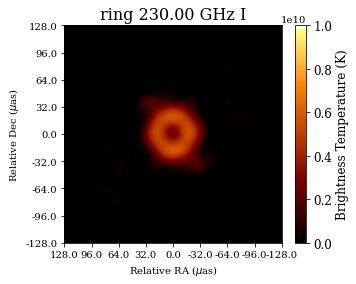

2022-07-27 16:44:24,976 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:24,977 INFO Display              :: Penalty--> 501.32939948621345
2022-07-27 16:44:25,092 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:25,094 INFO Display              :: Penalty--> 501.3186741445394
2022-07-27 16:44:25,218 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:25,219 INFO Display              :: Penalty--> 501.3186741445394
2022-07-27 16:44:25,346 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:25,347 INFO Display              :: Penalty--> 501.3186741445394
2022-07-27 16:44:25,487 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:25,489 INFO Display              :: Penalty--> 501.30794880286527
2022-07-27 16:44:25,605 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:25,607 INFO Display              :: Penalty--> 501.2972234611912
2022-07-27 16:44:25,724 INFO CountIterations      :: iteration = 7 / 25
20

2997.8718430506615
Data Fidelity:  6.340528128942362


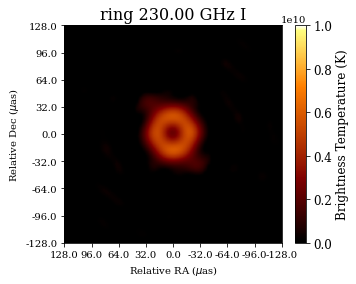

2022-07-27 16:44:28,400 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:44:28,402 INFO Display              :: Penalty--> 501.2665796278367
2022-07-27 16:44:28,524 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:44:28,525 INFO Display              :: Penalty--> 501.2665796278367
2022-07-27 16:44:28,638 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:44:28,640 INFO Display              :: Penalty--> 501.2665796278367
2022-07-27 16:44:28,762 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:44:28,764 INFO Display              :: Penalty--> 501.2665796278367
2022-07-27 16:44:28,896 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:44:28,898 INFO Display              :: Penalty--> 501.2665796278367
2022-07-27 16:44:29,014 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:44:29,016 INFO Display              :: Penalty--> 501.2665796278367
2022-07-27 16:44:29,141 INFO CountIterations      :: iteration = 7 / 25
2022

2997.935153210239
Data Fidelity:  6.227755391749204


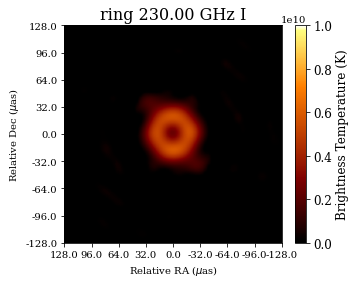

In [7]:
tau = 1

for i in range(3):
    #blur image to help global convergence
    img = img.blur_circ(res)
    data = handler.convert.ehtim_to_numpy(img)/rescaling

    #run mminimization
    wtfcts, img = handler.second_round_minimization(img.copy(), alpha, tau, maxiter=50, display=True)

    reco = handler.op(wtfcts)
    img = handler.wrapper.formatoutput(np.maximum(0, reco))


During the hard-threshold forward-backward splitting iterations of DoG-HiT effectively a mutliresolution support is computed, i.e. a set of all wavelet coefficients that are statistically significant to represent the information in the image. The multiresolution support is computed by the command handler.find_projection and stored as a projection operator handler.coordinate_proj. Note that handler.find_projection is called automatically internally when the last imaging round was done with the shortened handler.second_round_minimization command. 

The multiresolution support could be used to refine the reconstruction result. We minimize the data fidelity term specified by "data_term" without penalization by a gradient descent method. We have seen in tutorial 2 that this gives rise to spurious image artifacts. However, this time we only vary the wavelet coefficients in the multiresolution support (i.e. only the significant ones) which suppresses all possible artifacts during imaging.

The multiresolution support constrained gradient descent algorithm is done by the command handler.third_round. The stepsize parameter tau is found automatically by checkijgn convergence, only a start value has to be provided. Indeed, the procedure is converging (decreasing data fidelity) and improves the reconstruction.

In [8]:
wtfcts, img, tau = handler.third_round(wtfcts, data_term, tau=10, maxit=1000)

2022-07-27 16:47:38,725 INFO CountIterations      :: iteration = 1 / 5
2022-07-27 16:47:38,797 INFO Display              :: Data Fidelity--> 35.83512871434185
2022-07-27 16:47:38,965 INFO CountIterations      :: iteration = 2 / 5
2022-07-27 16:47:39,034 INFO Display              :: Data Fidelity--> 383.2097763321571
2022-07-27 16:47:39,230 INFO CountIterations      :: iteration = 3 / 5
2022-07-27 16:47:39,320 INFO Display              :: Data Fidelity--> 15855.971023225035
2022-07-27 16:47:39,483 INFO CountIterations      :: iteration = 4 / 5
2022-07-27 16:47:39,555 INFO Display              :: Data Fidelity--> 4760.979924967711
2022-07-27 16:47:39,724 INFO CountIterations      :: iteration = 5 / 5
2022-07-27 16:47:39,725 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2022-07-27 16:47:39,725 INFO Gradient_Descent     :: Stopping rule triggered.


Stepsize to big, try to run with smaller stepsize


2022-07-27 16:47:40,002 INFO CountIterations      :: iteration = 1 / 5
2022-07-27 16:47:40,075 INFO Display              :: Data Fidelity--> 28.016171587246333
2022-07-27 16:47:40,247 INFO CountIterations      :: iteration = 2 / 5
2022-07-27 16:47:40,323 INFO Display              :: Data Fidelity--> 159.67100270302424
2022-07-27 16:47:40,486 INFO CountIterations      :: iteration = 3 / 5
2022-07-27 16:47:40,562 INFO Display              :: Data Fidelity--> 7233.743931577122
2022-07-27 16:47:40,726 INFO CountIterations      :: iteration = 4 / 5
2022-07-27 16:47:40,803 INFO Display              :: Data Fidelity--> 4230.482648663363
2022-07-27 16:47:40,973 INFO CountIterations      :: iteration = 5 / 5
2022-07-27 16:47:40,974 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2022-07-27 16:47:40,975 INFO Gradient_Descent     :: Stopping rule triggered.
2022-07-27 16:47:41,256 INFO CountIterations      :: iteration = 1 / 5


Stepsize to big, try to run with smaller stepsize


2022-07-27 16:47:41,332 INFO Display              :: Data Fidelity--> 26.22561014227373
2022-07-27 16:47:41,507 INFO CountIterations      :: iteration = 2 / 5
2022-07-27 16:47:41,591 INFO Display              :: Data Fidelity--> 44.391400837282305
2022-07-27 16:47:41,784 INFO CountIterations      :: iteration = 3 / 5
2022-07-27 16:47:41,875 INFO Display              :: Data Fidelity--> 345.6950023711109
2022-07-27 16:47:42,042 INFO CountIterations      :: iteration = 4 / 5
2022-07-27 16:47:42,124 INFO Display              :: Data Fidelity--> 147.95527692269874
2022-07-27 16:47:42,295 INFO CountIterations      :: iteration = 5 / 5
2022-07-27 16:47:42,296 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2022-07-27 16:47:42,297 INFO Gradient_Descent     :: Stopping rule triggered.
2022-07-27 16:47:42,564 INFO CountIterations      :: iteration = 1 / 5


Stepsize to big, try to run with smaller stepsize


2022-07-27 16:47:42,641 INFO Display              :: Data Fidelity--> 26.151189707421292
2022-07-27 16:47:42,804 INFO CountIterations      :: iteration = 2 / 5
2022-07-27 16:47:42,877 INFO Display              :: Data Fidelity--> 26.237721719254775
2022-07-27 16:47:43,043 INFO CountIterations      :: iteration = 3 / 5
2022-07-27 16:47:43,115 INFO Display              :: Data Fidelity--> 32.71842185859583
2022-07-27 16:47:43,286 INFO CountIterations      :: iteration = 4 / 5
2022-07-27 16:47:43,363 INFO Display              :: Data Fidelity--> 68.86683711098634
2022-07-27 16:47:43,550 INFO CountIterations      :: iteration = 5 / 5
2022-07-27 16:47:43,551 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2022-07-27 16:47:43,551 INFO Gradient_Descent     :: Stopping rule triggered.
2022-07-27 16:47:43,828 INFO CountIterations      :: iteration = 1 / 5


Stepsize to big, try to run with smaller stepsize


2022-07-27 16:47:43,907 INFO Display              :: Data Fidelity--> 26.391380932382738
2022-07-27 16:47:44,078 INFO CountIterations      :: iteration = 2 / 5
2022-07-27 16:47:44,155 INFO Display              :: Data Fidelity--> 26.041823795717995
2022-07-27 16:47:44,328 INFO CountIterations      :: iteration = 3 / 5
2022-07-27 16:47:44,405 INFO Display              :: Data Fidelity--> 25.7410217480591
2022-07-27 16:47:44,553 INFO CountIterations      :: iteration = 4 / 5
2022-07-27 16:47:44,632 INFO Display              :: Data Fidelity--> 25.460811034924838
2022-07-27 16:47:44,797 INFO CountIterations      :: iteration = 5 / 5
2022-07-27 16:47:44,797 INFO CombineRules         :: Rule CountIterations(max_iterations=5) triggered.
2022-07-27 16:47:44,798 INFO Gradient_Descent     :: Stopping rule triggered.
2022-07-27 16:47:45,067 INFO CountIterations      :: iteration = 1 / 5
2022-07-27 16:47:45,137 INFO Display              :: Data Fidelity--> 24.942621562179408
2022-07-27 16:47:45,3

2022-07-27 16:47:56,051 INFO CountIterations      :: iteration = 30 / 1000
2022-07-27 16:47:56,154 INFO Display              :: Data Fidelity--> 20.276690242333032
2022-07-27 16:47:56,358 INFO CountIterations      :: iteration = 31 / 1000
2022-07-27 16:47:56,429 INFO Display              :: Data Fidelity--> 20.118903844125708
2022-07-27 16:47:56,587 INFO CountIterations      :: iteration = 32 / 1000
2022-07-27 16:47:56,652 INFO Display              :: Data Fidelity--> 19.96327562851466
2022-07-27 16:47:56,817 INFO CountIterations      :: iteration = 33 / 1000
2022-07-27 16:47:56,889 INFO Display              :: Data Fidelity--> 19.809752655497057
2022-07-27 16:47:57,049 INFO CountIterations      :: iteration = 34 / 1000
2022-07-27 16:47:57,141 INFO Display              :: Data Fidelity--> 19.65828436822125
2022-07-27 16:47:57,306 INFO CountIterations      :: iteration = 35 / 1000
2022-07-27 16:47:57,382 INFO Display              :: Data Fidelity--> 19.508822416819605
2022-07-27 16:47:5

2022-07-27 16:48:08,686 INFO Display              :: Data Fidelity--> 14.329830252355455
2022-07-27 16:48:08,852 INFO CountIterations      :: iteration = 81 / 1000
2022-07-27 16:48:08,940 INFO Display              :: Data Fidelity--> 14.240855483632796
2022-07-27 16:48:09,104 INFO CountIterations      :: iteration = 82 / 1000
2022-07-27 16:48:09,190 INFO Display              :: Data Fidelity--> 14.152756244120358
2022-07-27 16:48:09,343 INFO CountIterations      :: iteration = 83 / 1000
2022-07-27 16:48:09,413 INFO Display              :: Data Fidelity--> 14.065520222412662
2022-07-27 16:48:09,585 INFO CountIterations      :: iteration = 84 / 1000
2022-07-27 16:48:09,661 INFO Display              :: Data Fidelity--> 13.97913535560778
2022-07-27 16:48:09,827 INFO CountIterations      :: iteration = 85 / 1000
2022-07-27 16:48:09,895 INFO Display              :: Data Fidelity--> 13.893589822148186
2022-07-27 16:48:10,071 INFO CountIterations      :: iteration = 86 / 1000
2022-07-27 16:48:

2022-07-27 16:48:20,740 INFO Display              :: Data Fidelity--> 10.757786403258255
2022-07-27 16:48:20,901 INFO CountIterations      :: iteration = 131 / 1000
2022-07-27 16:48:21,003 INFO Display              :: Data Fidelity--> 10.701163032575371
2022-07-27 16:48:21,225 INFO CountIterations      :: iteration = 132 / 1000
2022-07-27 16:48:21,314 INFO Display              :: Data Fidelity--> 10.645008070853848
2022-07-27 16:48:21,499 INFO CountIterations      :: iteration = 133 / 1000
2022-07-27 16:48:21,567 INFO Display              :: Data Fidelity--> 10.589316308351053
2022-07-27 16:48:21,739 INFO CountIterations      :: iteration = 134 / 1000
2022-07-27 16:48:21,810 INFO Display              :: Data Fidelity--> 10.534082611948234
2022-07-27 16:48:22,001 INFO CountIterations      :: iteration = 135 / 1000
2022-07-27 16:48:22,074 INFO Display              :: Data Fidelity--> 10.479301923681367
2022-07-27 16:48:22,259 INFO CountIterations      :: iteration = 136 / 1000
2022-07-27

2022-07-27 16:48:33,014 INFO Display              :: Data Fidelity--> 8.413324541706045
2022-07-27 16:48:33,169 INFO CountIterations      :: iteration = 181 / 1000
2022-07-27 16:48:33,249 INFO Display              :: Data Fidelity--> 8.374965554526195
2022-07-27 16:48:33,401 INFO CountIterations      :: iteration = 182 / 1000
2022-07-27 16:48:33,476 INFO Display              :: Data Fidelity--> 8.33688605155126
2022-07-27 16:48:33,638 INFO CountIterations      :: iteration = 183 / 1000
2022-07-27 16:48:33,704 INFO Display              :: Data Fidelity--> 8.299083373172834
2022-07-27 16:48:33,872 INFO CountIterations      :: iteration = 184 / 1000
2022-07-27 16:48:33,944 INFO Display              :: Data Fidelity--> 8.261554892186433
2022-07-27 16:48:34,112 INFO CountIterations      :: iteration = 185 / 1000
2022-07-27 16:48:34,188 INFO Display              :: Data Fidelity--> 8.224298013294955
2022-07-27 16:48:34,359 INFO CountIterations      :: iteration = 186 / 1000
2022-07-27 16:48:

2022-07-27 16:48:45,078 INFO Display              :: Data Fidelity--> 6.792155528101614
2022-07-27 16:48:45,241 INFO CountIterations      :: iteration = 231 / 1000
2022-07-27 16:48:45,318 INFO Display              :: Data Fidelity--> 6.765050408844341
2022-07-27 16:48:45,490 INFO CountIterations      :: iteration = 232 / 1000
2022-07-27 16:48:45,566 INFO Display              :: Data Fidelity--> 6.738123534422947
2022-07-27 16:48:45,739 INFO CountIterations      :: iteration = 233 / 1000
2022-07-27 16:48:45,818 INFO Display              :: Data Fidelity--> 6.711373401271392
2022-07-27 16:48:45,985 INFO CountIterations      :: iteration = 234 / 1000
2022-07-27 16:48:46,054 INFO Display              :: Data Fidelity--> 6.684798521710003
2022-07-27 16:48:46,235 INFO CountIterations      :: iteration = 235 / 1000
2022-07-27 16:48:46,315 INFO Display              :: Data Fidelity--> 6.658397423737473
2022-07-27 16:48:46,481 INFO CountIterations      :: iteration = 236 / 1000
2022-07-27 16:48

2022-07-27 16:48:57,102 INFO Display              :: Data Fidelity--> 5.629044617902677
2022-07-27 16:48:57,271 INFO CountIterations      :: iteration = 281 / 1000
2022-07-27 16:48:57,343 INFO Display              :: Data Fidelity--> 5.609279489970158
2022-07-27 16:48:57,518 INFO CountIterations      :: iteration = 282 / 1000
2022-07-27 16:48:57,593 INFO Display              :: Data Fidelity--> 5.5896334616321806
2022-07-27 16:48:57,741 INFO CountIterations      :: iteration = 283 / 1000
2022-07-27 16:48:57,815 INFO Display              :: Data Fidelity--> 5.5701056217700105
2022-07-27 16:48:57,978 INFO CountIterations      :: iteration = 284 / 1000
2022-07-27 16:48:58,052 INFO Display              :: Data Fidelity--> 5.55069506783598
2022-07-27 16:48:58,219 INFO CountIterations      :: iteration = 285 / 1000
2022-07-27 16:48:58,302 INFO Display              :: Data Fidelity--> 5.53140090575492
2022-07-27 16:48:58,488 INFO CountIterations      :: iteration = 286 / 1000
2022-07-27 16:48

2022-07-27 16:49:09,646 INFO Display              :: Data Fidelity--> 4.770612151517398
2022-07-27 16:49:09,797 INFO CountIterations      :: iteration = 331 / 1000
2022-07-27 16:49:09,867 INFO Display              :: Data Fidelity--> 4.755833763051322
2022-07-27 16:49:10,023 INFO CountIterations      :: iteration = 332 / 1000
2022-07-27 16:49:10,097 INFO Display              :: Data Fidelity--> 4.741137759884024
2022-07-27 16:49:10,267 INFO CountIterations      :: iteration = 333 / 1000
2022-07-27 16:49:10,365 INFO Display              :: Data Fidelity--> 4.726523561150912
2022-07-27 16:49:10,530 INFO CountIterations      :: iteration = 334 / 1000
2022-07-27 16:49:10,615 INFO Display              :: Data Fidelity--> 4.711990590948218
2022-07-27 16:49:10,805 INFO CountIterations      :: iteration = 335 / 1000
2022-07-27 16:49:10,885 INFO Display              :: Data Fidelity--> 4.697538278281685
2022-07-27 16:49:11,060 INFO CountIterations      :: iteration = 336 / 1000
2022-07-27 16:49

2022-07-27 16:49:21,807 INFO Display              :: Data Fidelity--> 4.122273197562571
2022-07-27 16:49:21,986 INFO CountIterations      :: iteration = 381 / 1000
2022-07-27 16:49:22,066 INFO Display              :: Data Fidelity--> 4.110989186744988
2022-07-27 16:49:22,263 INFO CountIterations      :: iteration = 382 / 1000
2022-07-27 16:49:22,343 INFO Display              :: Data Fidelity--> 4.099763721713522
2022-07-27 16:49:22,528 INFO CountIterations      :: iteration = 383 / 1000
2022-07-27 16:49:22,604 INFO Display              :: Data Fidelity--> 4.088596417593743
2022-07-27 16:49:22,780 INFO CountIterations      :: iteration = 384 / 1000
2022-07-27 16:49:22,860 INFO Display              :: Data Fidelity--> 4.077486892540195
2022-07-27 16:49:23,035 INFO CountIterations      :: iteration = 385 / 1000
2022-07-27 16:49:23,114 INFO Display              :: Data Fidelity--> 4.066434767707854
2022-07-27 16:49:23,289 INFO CountIterations      :: iteration = 386 / 1000
2022-07-27 16:49

2022-07-27 16:49:34,294 INFO Display              :: Data Fidelity--> 3.6228897736717762
2022-07-27 16:49:34,445 INFO CountIterations      :: iteration = 431 / 1000
2022-07-27 16:49:34,527 INFO Display              :: Data Fidelity--> 3.6141150212759436
2022-07-27 16:49:34,703 INFO CountIterations      :: iteration = 432 / 1000
2022-07-27 16:49:34,773 INFO Display              :: Data Fidelity--> 3.605382790010526
2022-07-27 16:49:34,930 INFO CountIterations      :: iteration = 433 / 1000
2022-07-27 16:49:35,001 INFO Display              :: Data Fidelity--> 3.59669281703696
2022-07-27 16:49:35,165 INFO CountIterations      :: iteration = 434 / 1000
2022-07-27 16:49:35,236 INFO Display              :: Data Fidelity--> 3.5880448414448116
2022-07-27 16:49:35,384 INFO CountIterations      :: iteration = 435 / 1000
2022-07-27 16:49:35,461 INFO Display              :: Data Fidelity--> 3.5794386042351363
2022-07-27 16:49:35,620 INFO CountIterations      :: iteration = 436 / 1000
2022-07-27 16

2022-07-27 16:49:46,158 INFO Display              :: Data Fidelity--> 3.2315001773365317
2022-07-27 16:49:46,318 INFO CountIterations      :: iteration = 481 / 1000
2022-07-27 16:49:46,393 INFO Display              :: Data Fidelity--> 3.22456379036415
2022-07-27 16:49:46,559 INFO CountIterations      :: iteration = 482 / 1000
2022-07-27 16:49:46,637 INFO Display              :: Data Fidelity--> 3.2176588533324773
2022-07-27 16:49:46,821 INFO CountIterations      :: iteration = 483 / 1000
2022-07-27 16:49:46,890 INFO Display              :: Data Fidelity--> 3.210785182318733
2022-07-27 16:49:47,061 INFO CountIterations      :: iteration = 484 / 1000
2022-07-27 16:49:47,124 INFO Display              :: Data Fidelity--> 3.2039425946693756
2022-07-27 16:49:47,287 INFO CountIterations      :: iteration = 485 / 1000
2022-07-27 16:49:47,359 INFO Display              :: Data Fidelity--> 3.19713090898943
2022-07-27 16:49:47,517 INFO CountIterations      :: iteration = 486 / 1000
2022-07-27 16:4

2022-07-27 16:49:58,213 INFO Display              :: Data Fidelity--> 2.919874165590431
2022-07-27 16:49:58,375 INFO CountIterations      :: iteration = 531 / 1000
2022-07-27 16:49:58,451 INFO Display              :: Data Fidelity--> 2.914307679055477
2022-07-27 16:49:58,622 INFO CountIterations      :: iteration = 532 / 1000
2022-07-27 16:49:58,691 INFO Display              :: Data Fidelity--> 2.9087648207649712
2022-07-27 16:49:58,869 INFO CountIterations      :: iteration = 533 / 1000
2022-07-27 16:49:58,941 INFO Display              :: Data Fidelity--> 2.9032454593980295
2022-07-27 16:49:59,102 INFO CountIterations      :: iteration = 534 / 1000
2022-07-27 16:49:59,180 INFO Display              :: Data Fidelity--> 2.897749464491658
2022-07-27 16:49:59,347 INFO CountIterations      :: iteration = 535 / 1000
2022-07-27 16:49:59,419 INFO Display              :: Data Fidelity--> 2.892276706433886
2022-07-27 16:49:59,587 INFO CountIterations      :: iteration = 536 / 1000
2022-07-27 16:

2022-07-27 16:50:12,175 INFO Display              :: Data Fidelity--> 2.668105109151249
2022-07-27 16:50:12,337 INFO CountIterations      :: iteration = 581 / 1000
2022-07-27 16:50:12,408 INFO Display              :: Data Fidelity--> 2.663574586912723
2022-07-27 16:50:12,570 INFO CountIterations      :: iteration = 582 / 1000
2022-07-27 16:50:12,653 INFO Display              :: Data Fidelity--> 2.659062061529793
2022-07-27 16:50:12,814 INFO CountIterations      :: iteration = 583 / 1000
2022-07-27 16:50:12,883 INFO Display              :: Data Fidelity--> 2.654567437548448
2022-07-27 16:50:13,050 INFO CountIterations      :: iteration = 584 / 1000
2022-07-27 16:50:13,117 INFO Display              :: Data Fidelity--> 2.6500906201038874
2022-07-27 16:50:13,273 INFO CountIterations      :: iteration = 585 / 1000
2022-07-27 16:50:13,343 INFO Display              :: Data Fidelity--> 2.6456315149160066
2022-07-27 16:50:13,502 INFO CountIterations      :: iteration = 586 / 1000
2022-07-27 16:

2022-07-27 16:50:24,176 INFO Display              :: Data Fidelity--> 2.4618809813632714
2022-07-27 16:50:24,331 INFO CountIterations      :: iteration = 631 / 1000
2022-07-27 16:50:24,409 INFO Display              :: Data Fidelity--> 2.4581439539935785
2022-07-27 16:50:24,565 INFO CountIterations      :: iteration = 632 / 1000
2022-07-27 16:50:24,640 INFO Display              :: Data Fidelity--> 2.454420791426293
2022-07-27 16:50:24,827 INFO CountIterations      :: iteration = 633 / 1000
2022-07-27 16:50:24,903 INFO Display              :: Data Fidelity--> 2.4507114226891447
2022-07-27 16:50:25,076 INFO CountIterations      :: iteration = 634 / 1000
2022-07-27 16:50:25,145 INFO Display              :: Data Fidelity--> 2.4470157772015524
2022-07-27 16:50:25,295 INFO CountIterations      :: iteration = 635 / 1000
2022-07-27 16:50:25,368 INFO Display              :: Data Fidelity--> 2.4433337847709886
2022-07-27 16:50:25,528 INFO CountIterations      :: iteration = 636 / 1000
2022-07-27 

2022-07-27 16:50:38,352 INFO Display              :: Data Fidelity--> 2.290704685366717
2022-07-27 16:50:38,533 INFO CountIterations      :: iteration = 681 / 1000
2022-07-27 16:50:38,622 INFO Display              :: Data Fidelity--> 2.2875806959126495
2022-07-27 16:50:38,825 INFO CountIterations      :: iteration = 682 / 1000
2022-07-27 16:50:38,916 INFO Display              :: Data Fidelity--> 2.28446741972624
2022-07-27 16:50:39,178 INFO CountIterations      :: iteration = 683 / 1000
2022-07-27 16:50:39,262 INFO Display              :: Data Fidelity--> 2.281364799859439
2022-07-27 16:50:39,452 INFO CountIterations      :: iteration = 684 / 1000
2022-07-27 16:50:39,582 INFO Display              :: Data Fidelity--> 2.278272779483323
2022-07-27 16:50:39,809 INFO CountIterations      :: iteration = 685 / 1000
2022-07-27 16:50:39,884 INFO Display              :: Data Fidelity--> 2.275191301877852
2022-07-27 16:50:40,242 INFO CountIterations      :: iteration = 686 / 1000
2022-07-27 16:50

2022-07-27 16:50:51,972 INFO Display              :: Data Fidelity--> 2.1465071190555896
2022-07-27 16:50:52,126 INFO CountIterations      :: iteration = 731 / 1000
2022-07-27 16:50:52,209 INFO Display              :: Data Fidelity--> 2.143847277594122
2022-07-27 16:50:52,353 INFO CountIterations      :: iteration = 732 / 1000
2022-07-27 16:50:52,432 INFO Display              :: Data Fidelity--> 2.1411950205780492
2022-07-27 16:50:52,592 INFO CountIterations      :: iteration = 733 / 1000
2022-07-27 16:50:52,664 INFO Display              :: Data Fidelity--> 2.1385502588231073
2022-07-27 16:50:52,837 INFO CountIterations      :: iteration = 734 / 1000
2022-07-27 16:50:52,908 INFO Display              :: Data Fidelity--> 2.135912900201365
2022-07-27 16:50:53,080 INFO CountIterations      :: iteration = 735 / 1000
2022-07-27 16:50:53,170 INFO Display              :: Data Fidelity--> 2.13328284939862
2022-07-27 16:50:53,347 INFO CountIterations      :: iteration = 736 / 1000
2022-07-27 16:

2022-07-27 16:51:04,294 INFO Display              :: Data Fidelity--> 2.019663675972303
2022-07-27 16:51:04,479 INFO CountIterations      :: iteration = 781 / 1000
2022-07-27 16:51:04,546 INFO Display              :: Data Fidelity--> 2.0171678804255313
2022-07-27 16:51:04,714 INFO CountIterations      :: iteration = 782 / 1000
2022-07-27 16:51:04,795 INFO Display              :: Data Fidelity--> 2.0146751566495498
2022-07-27 16:51:04,951 INFO CountIterations      :: iteration = 783 / 1000
2022-07-27 16:51:05,019 INFO Display              :: Data Fidelity--> 2.0121866060524116
2022-07-27 16:51:05,189 INFO CountIterations      :: iteration = 784 / 1000
2022-07-27 16:51:05,266 INFO Display              :: Data Fidelity--> 2.0097033666897293
2022-07-27 16:51:05,447 INFO CountIterations      :: iteration = 785 / 1000
2022-07-27 16:51:05,520 INFO Display              :: Data Fidelity--> 2.0072265768442072
2022-07-27 16:51:05,700 INFO CountIterations      :: iteration = 786 / 1000
2022-07-27 

2022-07-27 16:51:17,016 INFO Display              :: Data Fidelity--> 1.9070493260140946
2022-07-27 16:51:17,184 INFO CountIterations      :: iteration = 831 / 1000
2022-07-27 16:51:17,273 INFO Display              :: Data Fidelity--> 1.9050382040919158
2022-07-27 16:51:17,430 INFO CountIterations      :: iteration = 832 / 1000
2022-07-27 16:51:17,499 INFO Display              :: Data Fidelity--> 1.9030343523818098
2022-07-27 16:51:17,670 INFO CountIterations      :: iteration = 833 / 1000
2022-07-27 16:51:17,737 INFO Display              :: Data Fidelity--> 1.9010376878240443
2022-07-27 16:51:17,893 INFO CountIterations      :: iteration = 834 / 1000
2022-07-27 16:51:17,968 INFO Display              :: Data Fidelity--> 1.899048130371125
2022-07-27 16:51:18,135 INFO CountIterations      :: iteration = 835 / 1000
2022-07-27 16:51:18,208 INFO Display              :: Data Fidelity--> 1.8970656028170072
2022-07-27 16:51:18,371 INFO CountIterations      :: iteration = 836 / 1000
2022-07-27 

2022-07-27 16:51:29,105 INFO Display              :: Data Fidelity--> 1.8142248792027482
2022-07-27 16:51:29,273 INFO CountIterations      :: iteration = 881 / 1000
2022-07-27 16:51:29,347 INFO Display              :: Data Fidelity--> 1.8125104844160576
2022-07-27 16:51:29,512 INFO CountIterations      :: iteration = 882 / 1000
2022-07-27 16:51:29,600 INFO Display              :: Data Fidelity--> 1.8108010731991206
2022-07-27 16:51:29,762 INFO CountIterations      :: iteration = 883 / 1000
2022-07-27 16:51:29,834 INFO Display              :: Data Fidelity--> 1.8090966185358117
2022-07-27 16:51:30,009 INFO CountIterations      :: iteration = 884 / 1000
2022-07-27 16:51:30,073 INFO Display              :: Data Fidelity--> 1.8073970937531172
2022-07-27 16:51:30,250 INFO CountIterations      :: iteration = 885 / 1000
2022-07-27 16:51:30,330 INFO Display              :: Data Fidelity--> 1.805702472510982
2022-07-27 16:51:30,480 INFO CountIterations      :: iteration = 886 / 1000
2022-07-27 

2022-07-27 16:51:41,199 INFO Display              :: Data Fidelity--> 1.7341434138452523
2022-07-27 16:51:41,363 INFO CountIterations      :: iteration = 931 / 1000
2022-07-27 16:51:41,445 INFO Display              :: Data Fidelity--> 1.7326501725753176
2022-07-27 16:51:41,603 INFO CountIterations      :: iteration = 932 / 1000
2022-07-27 16:51:41,675 INFO Display              :: Data Fidelity--> 1.731160854467547
2022-07-27 16:51:41,838 INFO CountIterations      :: iteration = 933 / 1000
2022-07-27 16:51:41,908 INFO Display              :: Data Fidelity--> 1.729675442535058
2022-07-27 16:51:42,075 INFO CountIterations      :: iteration = 934 / 1000
2022-07-27 16:51:42,145 INFO Display              :: Data Fidelity--> 1.7281939199090979
2022-07-27 16:51:42,311 INFO CountIterations      :: iteration = 935 / 1000
2022-07-27 16:51:42,381 INFO Display              :: Data Fidelity--> 1.7267162698374103
2022-07-27 16:51:42,541 INFO CountIterations      :: iteration = 936 / 1000
2022-07-27 1

2022-07-27 16:51:53,425 INFO Display              :: Data Fidelity--> 1.663978467741993
2022-07-27 16:51:53,577 INFO CountIterations      :: iteration = 981 / 1000
2022-07-27 16:51:53,655 INFO Display              :: Data Fidelity--> 1.6626625745415755
2022-07-27 16:51:53,821 INFO CountIterations      :: iteration = 982 / 1000
2022-07-27 16:51:53,895 INFO Display              :: Data Fidelity--> 1.661349874328417
2022-07-27 16:51:54,063 INFO CountIterations      :: iteration = 983 / 1000
2022-07-27 16:51:54,131 INFO Display              :: Data Fidelity--> 1.6600403545574896
2022-07-27 16:51:54,300 INFO CountIterations      :: iteration = 984 / 1000
2022-07-27 16:51:54,372 INFO Display              :: Data Fidelity--> 1.6587340027514903
2022-07-27 16:51:54,562 INFO CountIterations      :: iteration = 985 / 1000
2022-07-27 16:51:54,633 INFO Display              :: Data Fidelity--> 1.6574308065000247
2022-07-27 16:51:54,800 INFO CountIterations      :: iteration = 986 / 1000
2022-07-27 1

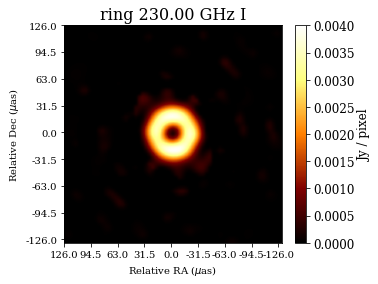

Final data fidelity term:  0.8093332200104517


In [9]:
img.display(cbar_lims=[0,0.004])

#print score
print("Final data fidelity term: ", handler.data_fidelity_closure(wtfcts))